#Red Neuronal en Pytorch para MNIST
Un autoencoder es un tipo de red neuronal artificial que se utiliza para aprender representaciones eficientes de datos, especialmente para reducir la dimensionalidad y la eliminación de ruido. La red está compuesta por dos componentes principales:  El Codificador (Encoder) que comprime la entrada al espacio latente (una representación en una menor dimensión) y el Decodificador (Decoder) que reconstruye la entrada original

Para este trabajo se escogió MNIST que es un dataset clásico para comenzar en problema de la clasificación de imágenes con redes neuronales. Contiene un gran número de imágenes de dígitos manuscritos (del 0 al 9), cada imagen es en escala de grises y tiene un tamaño de 28x28 píxeles. A cada pixel le corresponde un número entre 0 y 255 que representa la escala de grises (0 es blanco y 255 es negro)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import math
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Configuración del dispositivo (usa GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Configuración de semilla para reproducibilidad
torch.manual_seed(426) #últimos 3 dígitos de mi cédula
if torch.cuda.is_available():
    torch.cuda.manual_seed(426)

Dispositivo utilizado: cpu


## Sobre el Dataset
Como mencionamos escogimos MNIST. Como esto es un Autoencoder, utilizamos las mismas imágenes tanto como entrada como salida objetivo, ya que el objetivo es reconstruir la imagen original.
### Partición de los datos:
- Training (70%): Para entrenar el modelo y actualizar los pesos
- Validation (15%): Para monitorear el desempeño durante el entrenamiento y ajustar hiperparámetros
- Test (15%): Para evaluación final imparcial del modelo entrenado

Tener un conjunto de validación por separado tiene sus ventajas. Entre ellas están el monitoreo en tiempo real, detecta el overfitting;
Selección de hiperparámetros, optimiza sin contaminar el conjunto de test; para antes, para el entrenamiento cuando la validación deja de mejorar

### Preprocesamiento de Imágenes
Para preparar las imágenes de MNIST, aplicamos dos transformaciones clave:

ToTensor(): Esta función convierte las imágenes originales (en formato PIL) a tensores de PyTorch. Esto es esencial, ya que los modelos de PyTorch operan directamente con este tipo de datos.

Normalize(): Posteriormente, se normalizan los valores de los píxeles para que queden en el rango de [-1, 1].

Normalizar nos ayudará en mantener la estabilidad del entrenamiento, en la rápida convergencia y en el control de los gradientes: Ayuda a prevenir problemas comunes como los gradientes que explotan (overflow) o que desaparecen (underflow).


In [ ]:
# --- Definición de Transformaciones para Imágenes ---
# Aplicamos las transformaciones esenciales: tensorización y normalización.
img_transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5,), # Media para el canal único (escala de grises)
            (0.5,)  # Desviación estándar para el canal único
        )
    ]
)

# --- Carga de los Datasets Originales de MNIST ---
# Obtenemos los conjuntos de entrenamiento y prueba base de MNIST.
initial_train_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=img_transformations,
    download=True
)

initial_test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=img_transformations,
    download=True
)

# --- Combinación y Re-división del Dataset ---
# Concatenamos ambos conjuntos para una nueva partición 70-15-15.
from torch.utils.data import random_split, ConcatDataset
unified_mnist_data = ConcatDataset(
    [initial_train_data, initial_test_data]
)
total_data_points = len(unified_mnist_data)

# Calculamos los tamaños de los nuevos subconjuntos.
train_count = int(0.70 * total_data_points)
validation_count = int(0.15 * total_data_points)
# Aseguramos que el conjunto de prueba tome el resto para sumar el 100%.
test_count_final = total_data_points - train_count - validation_count

print(f"Total de elementos en el dataset: {total_data_points:,}")
print(f"División de elementos planificada:")
print(f"  - Entrenamiento: {train_count:,} (aprox. 70%)")
print(f"  - Validación:    {validation_count:,} (aprox. 15%)")
print(f"  - Prueba:        {test_count_final:,} (aprox. 15%)")


# Realizamos la división con una semilla fija para reproducibilidad.
my_train_set, my_val_set, my_test_set = random_split(
    unified_mnist_data,
    [train_count, validation_count, test_count_final],
    generator=torch.Generator().manual_seed(426) # Fija la semilla para la aleatoriedad
)

print("\nResultados de la división:")
print(f"  Conjunto de Entrenamiento: {len(my_train_set):,} imágenes ({len(my_train_set)/total_data_points*100:.1f}%)")
print(f"  Conjunto de Validación:    {len(my_val_set):,} imágenes ({len(my_val_set)/total_data_points*100:.1f}%)")
print(f"  Conjunto de Prueba:        {len(my_test_set):,} imágenes ({len(my_test_set)/total_data_points*100:.1f}%)")
print(f"  Total de elementos divididos: {len(my_train_set) + len(my_val_set) + len(my_test_set):,} (check!)")


# --- Configuración de Parámetros para DataLoaders ---
# Definimos el tamaño del lote y los pasos de acumulación de gradiente.
current_batch_size = 128
grad_acc_steps = 4 # Número de pasos para acumular los gradietnes


# --- Creación de los DataLoaders ---
# Esto permite cargar los datos en lotes de manera eficiente.
train_data_loader_obj = DataLoader(
    dataset=my_train_set,
    batch_size=current_batch_size,
    shuffle=True, # Mezclamos los datos solo para el entrenamiento
    num_workers=2,
    pin_memory=True
)

validation_data_loader_obj = DataLoader(
    dataset=my_val_set,
    batch_size=current_batch_size,
    shuffle=False, # No hay necesidad de mezclar para validación
    num_workers=2,
    pin_memory=True
)

test_data_loader_obj = DataLoader(
    dataset=my_test_set,
    batch_size=current_batch_size,
    shuffle=False, # Tampoco para el conjunto final de prueba
    num_workers=2,
    pin_memory=True
)

print(f"\nResumen de DataLoaders:")
print(f"  Tamaño de lote: {current_batch_size}")
print(f"  Pasos de acumulación de gradiente: {grad_acc_steps}")
print(f"  Tamaño de lote efectivo (con acumulación): {current_batch_size * grad_acc_steps}")
print(f"  Lotes por época (Entrenamiento): {len(train_data_loader_obj)}")
print(f"  Lotes por época (Validación):    {len(validation_data_loader_obj)}")
print(f"  Lotes por época (Prueba):        {len(test_data_loader_obj)}")


# --- Función para Analizar la Distribución de Clases ---
# Esta función helper nos ayuda a ver si los dígitos están balanceados en cada set.
def check_digit_distribution(dataset_input, name_of_set):
    """
    Examina y muestra la distribución de cada dígito (clase) dentro del conjunto de datos proporcionado.
    Funciona con datasets originales, Subsets y ConcatDatasets.
    """
    all_targets = []

    if hasattr(dataset_input, 'targets'):
        # Caso 1: Dataset original de torchvision (ej., MNIST completo)
        all_targets = dataset_input.targets
    elif hasattr(dataset_input, 'dataset') and hasattr(dataset_input.dataset, 'targets'):
        # Caso 2: Subset creado de un dataset original (ej., resultado de random_split sobre MNIST)
        all_targets = [dataset_input.dataset.targets[idx_val] for idx_val in dataset_input.indices]
        all_targets = torch.tensor(all_targets)
    elif hasattr(dataset_input, 'dataset') and hasattr(dataset_input.dataset, 'datasets'):
        # Caso 3: Subset creado de un ConcatDataset (como nuestros sets finales)
        print(f"  Extrayendo etiquetas de {name_of_set} de ConcatDataset... (puede demorar un poco)")
        temp_targets_list = []
        cum_length = 0
        for data_idx in dataset_input.indices: # Pequeño typo: data_idx en vez de idx_val
            current_idx_in_concat = data_idx - cum_length
            for sub_ds_item in dataset_input.dataset.datasets: # Renombrado sub_dataset a sub_ds_item
                if current_idx_in_concat < len(sub_ds_item):
                    if hasattr(sub_ds_item, 'targets'):
                        temp_targets_list.append(sub_ds_item.targets[current_idx_in_concat].item())
                    break # Salimos una vez que encontramos el sub-dataset correcto
                current_idx_in_concat -= len(sub_ds_item) # Ajustamos el índice para el siguiente sub-dataset
        all_targets = torch.tensor(temp_targets_list)
    else:
        # Caso 4: Fallback genérico si no se ajusta a las estructuras anteriores (más lento)
        print(f"  ¡Advertencia! Extrayendo etiquetas de {name_of_set} por iteración... (será muy lento!)")
        for i_elem in range(len(dataset_input)):
            _, label_val = dataset_input[i_elem] # Renombrado label a label_val
            all_targets.append(label_val)
        all_targets = torch.tensor(all_targets)

    # Contamos la ocurrencia de cada dígito.
    unique_vals, counts_of_vals = torch.unique(all_targets, return_counts=True)
    print(f"\nDistribución de clases en el {name_of_set}:")
    for digit_char, count_val in zip(unique_vals.tolist(), counts_of_vals.tolist()):
        print(f"    Dígito {digit_char}: {count_val:,} muestras ({count_val/len(all_targets)*100:.1f}%)")

# Aplicamos la función a cada uno de nuestros conjuntos de datos ya divididos.
check_digit_distribution(my_train_set, "Conjunto de Entrenamiento")
check_digit_distribution(my_val_set, "Conjunto de Validación")
check_digit_distribution(my_test_set, "Conjunto de Prueba Final")

Total de elementos en el dataset: 70,000
División de elementos planificada:
  - Entrenamiento: 49,000 (aprox. 70%)
  - Validación:    10,500 (aprox. 15%)
  - Prueba:        10,500 (aprox. 15%)

Resultados de la división:
  Conjunto de Entrenamiento: 49,000 imágenes (70.0%)
  Conjunto de Validación:    10,500 imágenes (15.0%)
  Conjunto de Prueba:        10,500 imágenes (15.0%)
  Total de elementos divididos: 70,000 (check!)

Resumen de DataLoaders:
  Tamaño de lote: 128
  Pasos de acumulación de gradiente: 4
  Tamaño de lote efectivo (con acumulación): 512
  Lotes por época (Entrenamiento): 383
  Lotes por época (Validación):    83
  Lotes por época (Prueba):        83
  Extrayendo etiquetas de Conjunto de Entrenamiento de ConcatDataset... (puede demorar un poco)

Distribución de clases en el Conjunto de Entrenamiento:
    Dígito 0: 4,855 muestras (9.9%)
    Dígito 1: 5,459 muestras (11.1%)
    Dígito 2: 4,898 muestras (10.0%)
    Dígito 3: 5,003 muestras (10.2%)
    Dígito 4: 4,789 mu

##Arquitectura de nuestro Autoencoder
La arquitectura del Autoencoder se compone de dos bloques fundamentales:

### Codificador (Encoder)
Objetivo: Comprimir la entrada de tamaño 28x28 (784 píxeles) en una representación más compacta.

Diseño: Capas lineales sucesivas que reducen progresivamente la dimensionalidad.

Activación: Se utiliza la función ReLU para introducir no linealidades.

Espacio latente: Se alcanza una representación comprimida de 64 dimensiones.

### Decodificador (Decoder)
Objetivo: Reconstruir la imagen original a partir de la representación latente.

Diseño: Capas lineales que aumentan gradualmente la dimensión hasta alcanzar el tamaño original.

Activación: Se emplea ReLU en las capas ocultas y Tanh en la capa de salida.

Salida final: Imagen reconstruida de 28x28 píxeles.

A continuación una implementación  de esto

In [ ]:
class DigitCompressor(nn.Module):
    """
    Implementa un Autoencoder para compresión y reconstrucción de dígitos.

    Este modelo mapea imágenes de entrada a un espacio de menor dimensión (latente)
    y luego intenta reconstruir la imagen original desde esa representación comprimida.
    """
    def __init__(self, input_size=784, layer_sizes=[512, 256, 128], bottleneck_size=64):
        """
        Inicializa la arquitectura del Autoencoder.

        Args:
            input_size (int): La dimensión esperada de la imagen aplanada (ej. 28*28 = 784 para MNIST).
            layer_sizes (list): Una lista con las dimensiones de las capas ocultas del encoder.
            bottleneck_size (int): La dimensión del espacio latente (el "cuello de botella").
        """
        super(DigitCompressor, self).__init__()

        self.input_dim = input_size # typo: input_dim en lugar de input_size para recordar
        self.latent_space_dim = bottleneck_size

        # --- Sección del ENCODER ---
        # Componente que reduce la dimensionalidad de los datos de entrada.
        encoder_network_components = []
        current_dim = input_size

        # Construcción de las capas ocultas del codificador.
        for h_dim in layer_sizes:
            encoder_network_components.extend(
                [
                    nn.Linear(current_dim, h_dim),
                    nn.ReLU(inplace=True), # Activación ReLU para introducir no-linealidad
                    nn.Dropout(0.2)        # Dropout para regularización y evitar overfitting
                ]
            )
            current_dim = h_dim

        # La última capa del encoder mapea a nuestro espacio latente.
        encoder_network_components.append(
            nn.Linear(current_dim, bottleneck_size)
        )

        self.the_encoder = nn.Sequential(*encoder_network_components)

        # --- Sección del DECODER ---
        # Componente que reconstruye los datos a partir de la representación latente.
        decoder_network_components = []
        current_dim = bottleneck_size

        # Construcción de las capas ocultas del decodificador.
        # Las capas se construyen en orden inverso a las del encoder para simetria.
        for h_dim in reversed(layer_sizes): # Usamos 'reversed' para invertir el orden
            decoder_network_components.extend(
                [
                    nn.Linear(current_dim, h_dim),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.2)
                ]
            )
            current_dim = h_dim

        # La capa final del decoder reconstruye la imagen a su dimensión original.
        decoder_network_components.extend(
            [
                nn.Linear(current_dim, input_size),
                nn.Tanh() # Función de activación Tanh para asegurar salida en rango [-1, 1]
            ]
        )

        self.the_decoder = nn.Sequential(*decoder_network_components)

        # Inicializamos los pesos de la red para un mejor rendimiento.
        self._set_up_weights()

    def _set_up_weights(self):
        """
        Aplica la inicialización de pesos Xavier (Glorot uniforme)
        para mejorar la estabilidad y velocidad de convergencia del entrenamiento.
        """
        for modl in self.modules():
            if isinstance(modl, nn.Linear):
                nn.init.xavier_uniform_(modl.weight)
                nn.init.constant_(modl.bias, 0)

    def encode_data(self, input_data):
        """
        Pasa los datos de entrada a través del encoder para obtener su representación latente.
        """
        return self.the_encoder(input_data)

    def decode_data(self, latent_repr):
        """
        Reconstruye los datos originales a partir de la representación latente
        pasándolos por el decoder.
        """
        return self.the_decoder(latent_repr)

    def forward(self, input_tensor):
        """
        Define el pase hacia adelante completo del Autoencoder.
        Procesa una imagen de entrada, la comprime y luego la reconstruye.

        Args:
            input_tensor (torch.Tensor): Tensor de entrada (imágenes) con forma (batch_size, channels, height, width).

        Returns:
            tuple: Un tuple que contiene:
                - torch.Tensor: La imagen reconstruida con la misma forma que la entrada.
                - torch.Tensor: La representación latente (vector comprimido).
        """
        # Aplanamos la imagen de 4D (batch, canal, alto, ancho) a 2D (batch, píxeles totales)
        flattened_input = input_tensor.view(input_tensor.size(0), -1)

        # Codificamos la entrada a su forma latente
        latent_vector = self.encode_data(flattened_input)

        # Decodificamos el vector latente para reconstruir la imagen
        reconstructed_output = self.decode_data(latent_vector)

        # Devolvemos la reconstrucción a su forma original de imagen (4D)
        reconstructed_output = reconstructed_output.view(input_tensor.size())

        return reconstructed_output, latent_vector

# --- Creación e Inspección del Modelo ---
model_instance = DigitCompressor().to(device)

# Imprimimos un resumen de la arquitectura del modelo.
print("Estructura del compresor de dígitos (Autoencoder):")
print(model_instance)
print(f"\nTotal de parámetros en el modelo: {sum(p.numel() for p in model_instance.parameters()):,}")
print(f"Parámetros que se ajustarán (entrenables): {sum(p.numel() for p in model_instance.parameters() if p.requires_grad):,}")

Estructura del compresor de dígitos (Autoencoder):
DigitCompressor(
  (the_encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
  )
  (the_decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=512, out

## Gradient Accumulation
La técnica de acumulación de gradientes (Gradient Accumulation) permite simular un tamaño de batch más grande sin aumentar el consumo de memoria, lo cual resulta especialmente útil en los siguientes casos:

- Limitaciones de memoria: Cuando la GPU no permite usar batch sizes grandes.

- Estabilidad de entrenamiento: Batch sizes mayores tienden a generar gradientes más estables.

- Convergencia: Puede favorecer una mejor convergencia del modelo.

El método consiste en procesar varios mini-batches sin actualizar inmediatamente los pesos del modelo; en su lugar, se acumulan los gradientes generados por cada mini-batch. Una vez que se han procesado todos los mini-batches definidos para la acumulación, se calcula el promedio de los gradientes acumulados y se realiza una única actualización de los pesos. Esto permite simular un batch size más grande sin requerir memoria adicional.

##Función de pérdida
Se utiliza el Error Cuadrático Medio (MSE) como función de pérdida, ya que:

- Es adecuada para tareas de reconstrucción.

- Penaliza con mayor fuerza las diferencias grandes entre la imagen original y la reconstruida.

- Ofrece gradientes suaves, lo que facilita el entrenamiento del modelo.

In [ ]:
# --- Parámetros Fundamentales para el Entrenamiento ---
# Estos valores dictarán cómo se comporta nuestro proceso de aprendizaje.
learning_rate = 1e-3  # La tasa inicial a la que el modelo ajusta sus pesos.
num_epochs = 20       # Cuántas veces completas el modelo verá todo el dataset.
weight_decay = 1e-5   # Un término de regularización L2 para prevenir el sobreajuste.

# --- Definición de la Función de Pérdida ---
# La métrica que cuantifica la diferencia entre las imágenes originales y las reconstruidas.
criterion = nn.MSELoss() # Usamos el Error Cuadrático Medio, común para tareas de reconstrucción.

# --- Configuración del Optimizador ---
# El algoritmo que se encarga de actualizar los pesos del autoencoder.
# Adam es una elección popular por su eficiencia y adaptabilidad.
optimizer = optim.Adam(
    model_instance.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999) # Parámetros predeterminados de Adam para la estimación del momento.
)

# --- Configuración del Scheduler de Tasa de Aprendizaje ---
# Una herramienta para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento.
# Reduce la tasa si el rendimiento en validación no mejora después de cierto número de épocas.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',    # Monitorearemos una métrica que buscamos minimizar
    factor=0.5,    # Si se activa, la tasa de aprendizaje se multiplicará por 0.5.
    patience=3     # Esperará 3 épocas sin mejora antes de aplicar la reducción.
    # ,verbose=True
)

# --- Resumen de la Configuración ---
# Una impresión para confirmar los hiperparámetros elegidos.
print("Detalles de la configuración de entrenamiento:")
print(f"  Tasa de aprendizaje (LR): {learning_rate}")
print(f"  Total de épocas: {num_epochs}")
print(f"  Decaimiento de peso (L2): {weight_decay}")
print(f"  Tipo de optimizador: Adam")
print(f"  Pérdida utilizada: MSE (Mean Squared Error)")
print(f"  Programador de LR: ReduceLRonPleteau")

Detalles de la configuración de entrenamiento:
  Tasa de aprendizaje (LR): 0.001
  Total de épocas: 20
  Decaimiento de peso (L2): 1e-05
  Tipo de optimizador: Adam
  Pérdida utilizada: MSE (Mean Squared Error)
  Programador de LR: ReduceLRonPleteau


## Training Loop con Gradient Accumulation y Validación
El training loop implementa la técnica de gradient accumulation y utiliza un conjunto de validación separado siguiendo estos pasos:

### Proceso de entrenamiento por época:
1. Inicialización: Resetear gradientes acumulados y contadores
2.  Fase de Entrenamiento:
  - Iterar por batches del conjunto de entrenamiento
  - Forward pass para obtener reconstrucción
  - Calcular pérdida y normalizarla por accumulation_steps
  - Backward pass para calcular gradientes
  - Acumular gradientes sin actualizar pesos
3. Actualización: Cada accumulation_steps, actualizar pesos y resetear gradientes
4. Fase de Validación:
  - Evaluar el modelo en el conjunto de validación (sin actualizar pesos)
  . Calcular métricas de validación para monitoreo
5. Logging: Registrar métricas y progreso
6. Learning Rate Scheduling: Ajustar learning rate basado en pérdida de validación

In [ ]:
def train_autoencoder(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler,
                      num_epochs, accumulation_steps, device):
    """
    Entrena el autoencoder usando gradient accumulation con validación separada

    Args:
        model: Modelo Autoencoder
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación
        test_loader: DataLoader de prueba (solo para evaluación final)
        criterion: Función de pérdida
        optimizer: Optimizador
        scheduler: Learning rate scheduler
        num_epochs: Número de épocas
        accumulation_steps: Pasos para gradient accumulation
        device: Dispositivo (CPU o GPU)

    Returns:
        train_losses: Lista de pérdidas de entrenamiento
        val_losses: Lista de pérdidas de validación
        test_loss_final: Pérdida final en conjunto de test
    """

    model.train()
    train_losses = []
    val_losses = []

    print("Iniciando entrenamiento...")
    print("=" * 70)

    for epoch in range(num_epochs):
        start_time = time.time()

        # =============== FASE DE ENTRENAMIENTO ===============
        model.train()
        total_train_loss = 0.0
        num_batches = 0

        # Inicializar acumuladores
        optimizer.zero_grad()
        accumulated_loss = 0.0

        # Barra de progreso para el entrenamiento
        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Entrenamiento]',
                                  leave=False)

        for batch_idx, (data, _) in enumerate(train_pbar):
            data = data.to(device, non_blocking=True)

            # Forward pass
            reconstruction, latent = model(data)

            # Calcular pérdida y normalizar por accumulation_steps
            loss = criterion(reconstruction, data) / accumulation_steps

            # Backward pass (acumular gradientes)
            loss.backward()

            # Acumular pérdida para logging
            accumulated_loss += loss.item()

            # Actualizar pesos cada accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0:
                # Aplicar gradient clipping para estabilidad
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Actualizar pesos
                optimizer.step()
                optimizer.zero_grad()

                # Registrar pérdida acumulada
                total_train_loss += accumulated_loss
                num_batches += 1
                accumulated_loss = 0.0

            # Actualizar barra de progreso
            train_pbar.set_postfix({'Loss': f'{loss.item() * accumulation_steps:.6f}'})

        # Manejar el último batch si no es múltiplo de accumulation_steps
        if (len(train_loader)) % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += accumulated_loss
            num_batches += 1

        # Calcular pérdida promedio de entrenamiento
        avg_train_loss = total_train_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_train_loss)

        # =============== FASE DE VALIDACIÓN ===============
        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} [Validación]',
                                 leave=False)

            for data, _ in val_pbar:
                data = data.to(device, non_blocking=True)

                # Forward pass
                reconstruction, _ = model(data)

                # Calcular pérdida
                loss = criterion(reconstruction, data)
                total_val_loss += loss.item()
                num_val_batches += 1

                # Actualizar barra de progreso
                val_pbar.set_postfix({'Val Loss': f'{loss.item():.6f}'})

        # Calcular pérdida promedio de validación
        avg_val_loss = total_val_loss / num_val_batches
        val_losses.append(avg_val_loss)

        # Actualizar learning rate basado en validación
        scheduler.step(avg_val_loss)

        # Tiempo de época
        epoch_time = time.time() - start_time

        # Logging
        print(f"Época {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
              f"Tiempo: {epoch_time:.1f}s")

        # Early stopping basado en validación
        if epoch > 5 and avg_val_loss > val_losses[-2]:
            patience_counter = getattr(train_autoencoder, 'patience_counter', 0) + 1
            train_autoencoder.patience_counter = patience_counter

            if patience_counter >= 3:
                print(f"Early stopping en época {epoch+1} - Validación no mejora")
                break
        else:
            train_autoencoder.patience_counter = 0

    # =============== EVALUACIÓN FINAL EN TEST ===============
    print("=" * 70)
    print("Evaluando en conjunto de test...")

    model.eval()
    total_test_loss = 0.0
    num_test_batches = 0

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Evaluación Final [Test]')

        for data, _ in test_pbar:
            data = data.to(device, non_blocking=True)

            # Forward pass
            reconstruction, _ = model(data)

            # Calcular pérdida
            loss = criterion(reconstruction, data)
            total_test_loss += loss.item()
            num_test_batches += 1

            # Actualizar barra de progreso
            test_pbar.set_postfix({'Test Loss': f'{loss.item():.6f}'})

    test_loss_final = total_test_loss / num_test_batches

    print("=" * 70)
    print("Entrenamiento completado!")
    print(f"Pérdida final en conjunto de test: {test_loss_final:.6f}")

    return train_losses, val_losses, test_loss_final

# Ejecutar entrenamiento con validación separada
train_losses, val_losses, test_loss_final = train_autoencoder(
    model=model_instance,
    train_loader=train_data_loader_obj,
    val_loader=validation_data_loader_obj,
    test_loader=test_data_loader_obj,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    accumulation_steps=grad_acc_steps,
    device=device
)

Iniciando entrenamiento...


Época  1/20 | Train Loss: 0.282391 | Val Loss: 0.195207 | LR: 1.00e-03 | Tiempo: 13.2s


Época  2/20 | Train Loss: 0.176584 | Val Loss: 0.136067 | LR: 1.00e-03 | Tiempo: 13.2s


Época  3/20 | Train Loss: 0.147589 | Val Loss: 0.117341 | LR: 1.00e-03 | Tiempo: 13.7s


Época  4/20 | Train Loss: 0.134601 | Val Loss: 0.105838 | LR: 1.00e-03 | Tiempo: 13.2s


Época  5/20 | Train Loss: 0.125942 | Val Loss: 0.097654 | LR: 1.00e-03 | Tiempo: 13.1s


Época  6/20 | Train Loss: 0.119891 | Val Loss: 0.091569 | LR: 1.00e-03 | Tiempo: 13.1s


Época  7/20 | Train Loss: 0.115235 | Val Loss: 0.087400 | LR: 1.00e-03 | Tiempo: 13.2s


Época  8/20 | Train Loss: 0.112093 | Val Loss: 0.084517 | LR: 1.00e-03 | Tiempo: 13.1s


Época  9/20 | Train Loss: 0.109388 | Val Loss: 0.081594 | LR: 1.00e-03 | Tiempo: 13.3s


Época 10/20 | Train Loss: 0.107188 | Val Loss: 0.079203 | LR: 1.00e-03 | Tiempo: 13.3s


Época 11/20 | Train Loss: 0.105339 | Val Loss: 0.077240 | LR: 1.00e-03 | Tiempo: 14.0s


Época 12/20 | Train Loss: 0.103805 | Val Loss: 0.076258 | LR: 1.00e-03 | Tiempo: 13.3s


Época 13/20 | Train Loss: 0.102611 | Val Loss: 0.075863 | LR: 1.00e-03 | Tiempo: 13.4s


Época 14/20 | Train Loss: 0.101750 | Val Loss: 0.074124 | LR: 1.00e-03 | Tiempo: 13.2s


Época 15/20 | Train Loss: 0.100695 | Val Loss: 0.073067 | LR: 1.00e-03 | Tiempo: 13.2s


Época 16/20 | Train Loss: 0.099699 | Val Loss: 0.072381 | LR: 1.00e-03 | Tiempo: 13.3s


Época 17/20 | Train Loss: 0.099036 | Val Loss: 0.071466 | LR: 1.00e-03 | Tiempo: 13.3s


Época 18/20 | Train Loss: 0.098150 | Val Loss: 0.070783 | LR: 1.00e-03 | Tiempo: 13.6s


Época 19/20 | Train Loss: 0.097333 | Val Loss: 0.069585 | LR: 1.00e-03 | Tiempo: 13.8s


Época 20/20 | Train Loss: 0.096706 | Val Loss: 0.069408 | LR: 1.00e-03 | Tiempo: 13.3s
Evaluando en conjunto de test...


Evaluación Final [Test]: 100%|██████████| 83/83 [00:01<00:00, 44.36it/s, Test Loss=0.096387]

Entrenamiento completado!
Pérdida final en conjunto de test: 0.070013


## Visualización de Resultados
Se comparan las imágenes originales con las imágenes recreadas para convencernos de que los resultados obtenidos son decentes, si no se estaba convencido ya con la pérdida total presentada en la anterior celda

=== ANÁLISIS EN CONJUNTO DE VALIDACIÓN ===


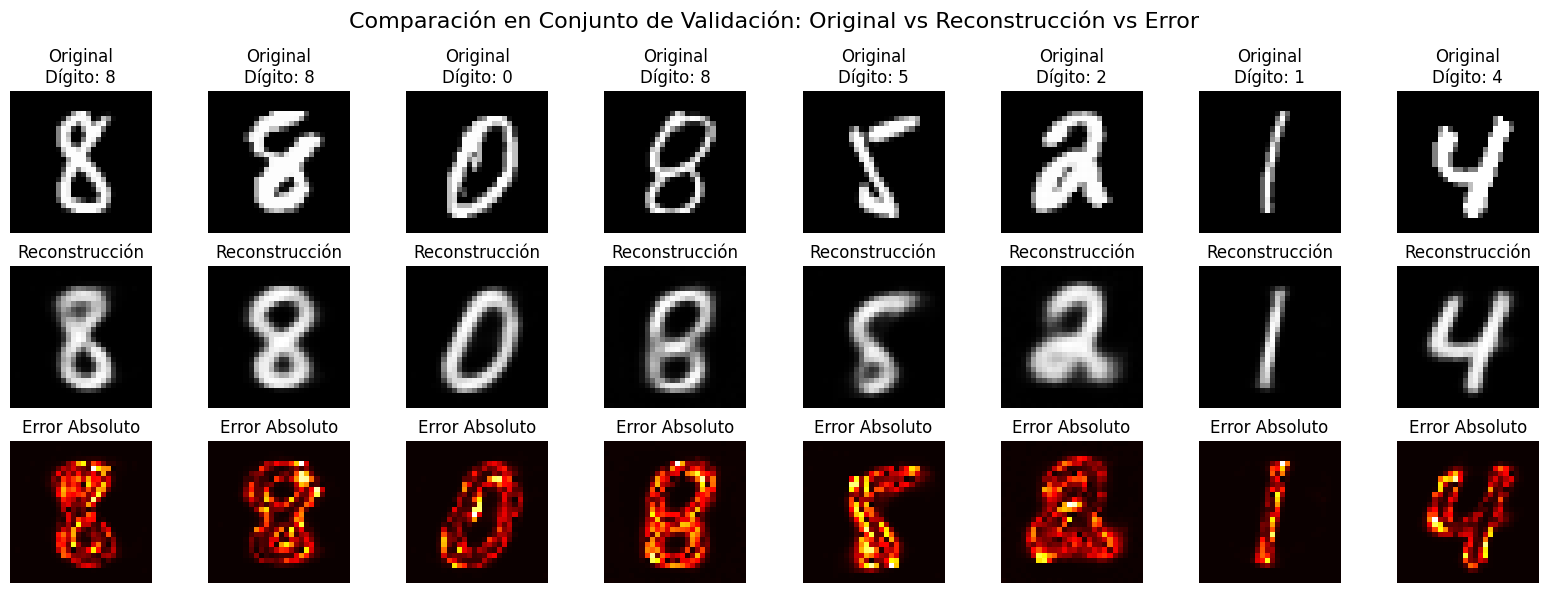

Métricas de reconstrucción en Validación:
MSE promedio por imagen: 0.079564
MSE mínimo: 0.016349
MSE máximo: 0.123102
Desviación estándar del MSE: 0.031853

=== ANÁLISIS EN CONJUNTO DE PRUEBA FINAL ===


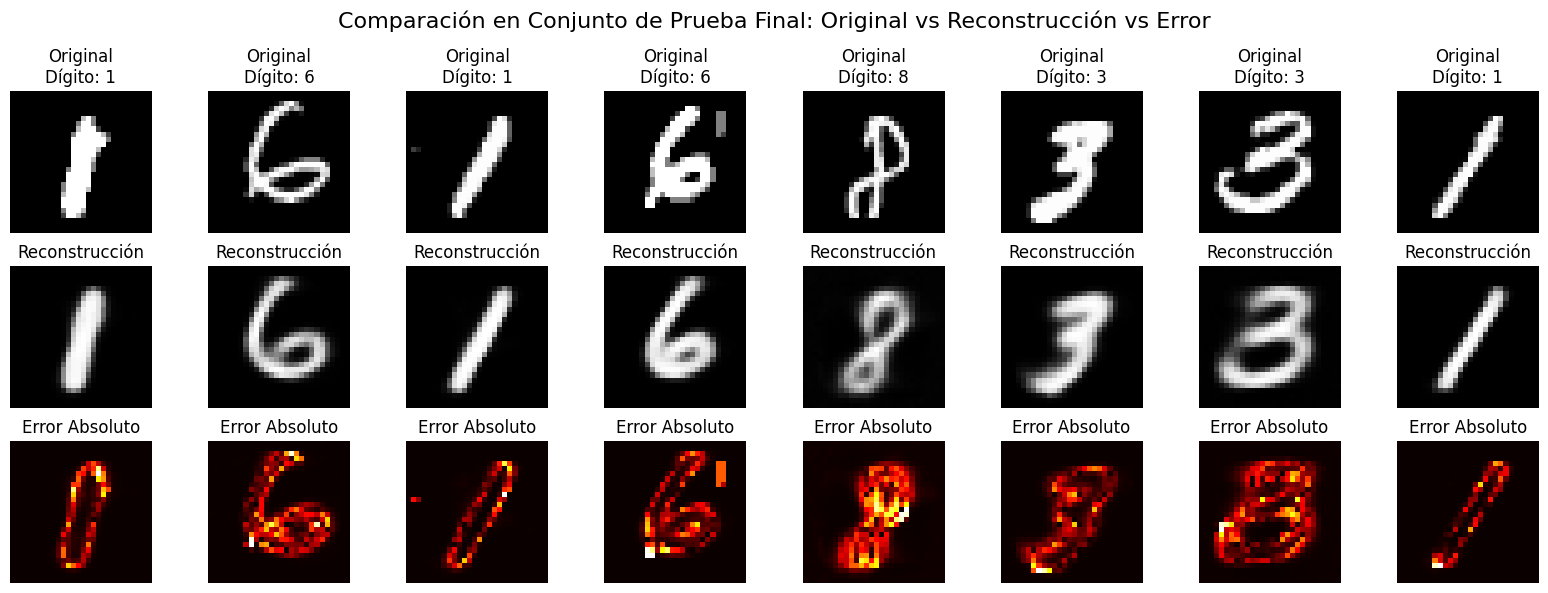

Métricas de reconstrucción en Prueba Final:
MSE promedio por imagen: 0.067949
MSE mínimo: 0.017436
MSE máximo: 0.139976
Desviación estándar del MSE: 0.041432


In [ ]:
def visualize_reconstructions(model, data_loader, device, num_samples=8, dataset_name="Validación"):
    """
    Visualiza imágenes originales y sus reconstrucciones

    Args:
        model: Modelo entrenado
        data_loader: DataLoader de datos
        device: Dispositivo (CPU o GPU)
        num_samples: Número de muestras a visualizar
        dataset_name: Nombre del dataset para el título
    """
    model.eval()

    # Obtener una muestra de datos
    with torch.no_grad():
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)

        # Obtener reconstrucciones
        reconstructions, latent_representations = model(images)

        # Mover a CPU para visualización
        images = images.cpu()
        reconstructions = reconstructions.cpu()

        # Crear figura
        fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))

        for i in range(num_samples):
            # Imagen original
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original\nDígito: {labels[i].item()}')
            axes[0, i].axis('off')

            # Imagen reconstruida
            axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstrucción')
            axes[1, i].axis('off')

            # Diferencia (error de reconstrucción)
            difference = torch.abs(images[i] - reconstructions[i])
            axes[2, i].imshow(difference.squeeze(), cmap='hot')
            axes[2, i].set_title('Error Absoluto')
            axes[2, i].axis('off')

        plt.suptitle(f'Comparación en Conjunto de {dataset_name}: Original vs Reconstrucción vs Error', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Calcular métricas de reconstrucción
        mse_per_image = torch.mean((images - reconstructions) ** 2, dim=[1, 2, 3])
        print(f"Métricas de reconstrucción en {dataset_name}:")
        print(f"MSE promedio por imagen: {torch.mean(mse_per_image):.6f}")
        print(f"MSE mínimo: {torch.min(mse_per_image):.6f}")
        print(f"MSE máximo: {torch.max(mse_per_image):.6f}")
        print(f"Desviación estándar del MSE: {torch.std(mse_per_image):.6f}")

# Visualizar reconstrucciones en conjunto de validación
print("=== ANÁLISIS EN CONJUNTO DE VALIDACIÓN ===")
visualize_reconstructions(model=model_instance, data_loader=validation_data_loader_obj, device=device, num_samples=8, dataset_name="Validación")

# Visualizar reconstrucciones en conjunto de prueba
print("\n=== ANÁLISIS EN CONJUNTO DE PRUEBA FINAL ===")
visualize_reconstructions(model=model_instance, data_loader=test_data_loader_obj, device=device, num_samples=8, dataset_name="Prueba Final")

# Extra 1: ¿Vision Transformers o Redes Convolucionales?
### Vision Transformers:
Los ViT's aplican la arquitectura Transformer —originalmente diseñada para procesamiento de lenguaje natural. En vez de analizar la imagen pixel a pixel usando filtros locales, los Vision Transformers fragmentan la imagen en pequeños parches cuadrados, que se consideran como unidades independientes o "tokens". Cada uno de estos parches se transforma en un vector que resume la información de esa zona específica. Luego, mediante mecanismos de atención, cada parche puede interactuar y establecer relaciones con todos los demás parches de la imagen al mismo tiempo, sin importar la distancia entre ellos.

### Redes Convolucionales (tradicionales):
Las redes convolucionales (CNNs) analizan las imágenes utilizando filtros locales que capturan progresivamente características cada vez más complejas. Al principio detectan elementos básicos como bordes y texturas, y en capas más profundas integran esa información para reconocer formas más elaboradas y, finalmente, objetos completos. Este enfoque sigue una estructura jerárquica, construyendo la comprensión de la imagen de manera gradual, mientras conservan la distribución espacial mediante los mapas de características.

Su principal diferencia es que las CNNs aprenden primero lo local y luego lo global; ViT aprende lo global desde el principio.

¿Cuál escoger?
Una guía útil para decidir entre Vision Transformers (ViT) y redes convolucionales (CNNs) la proporciona el artículo "A ConvNet for the 2020s" (Liu et al., 2022), que en su apartado de conclusiones comparan ambas arquitecturas:

<< ... los Vision Transformers, ..., comenzaron a superar a las redes convolucionales (ConvNets) como la opción preferida para arquitecturas base en visión por computador. La convicción generalizada es que los Vision Transformers son más precisos, eficientes y escalables que las ConvNets >> Que sugiere los Vision Transformers son superiores a las redes Convolucionales bajo las condiciones adecuadas.

Los ViT son preferibles cuando se dispone de grandes volúmenes de datos de entrenamiento y potencia computacional suficiente. Gracias a su capacidad de capturar relaciones globales desde el principio mediante mecanismos de atención, suelen ofrecer mejor rendimiento en tareas complejas como clasificación fina, detección y segmentación, especialmente en escenarios con preentrenamiento masivo y transfer learning.

Por otro lado, las CNNs siguen siendo una excelente opción cuando se trabaja con datasets más pequeños o recursos computacionales limitados, ya que incorporan inductivos bias locales (como la traslación invariante y la jerarquía espacial) que les permiten generalizar mejor sin necesidad de tanta data. Además, son más eficientes en términos de parámetros y entrenamiento.



En el desarrollo de este trabajo hemos construido básicamente una red convolucional. Ahora implementemos un vision transformer y comparemos resultados.

In [ ]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange


# --- 1. Definición del Vision Transformer (ViT) ---

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 1, patch_size: int = 7, emb_size: int = 64):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            # Conv2d para "proyectar" los parches y aplanar
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e h w -> b (h w) e'), # Aplanar (h w) en una secuencia de parches
        )

    def forward(self, x):
        return self.projection(x)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size: int = 64, num_heads: int = 4, dropout: float = 0.0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads

        self.qkv_proj = nn.Linear(emb_size, emb_size * 3) # Proyecciones para Q, K, V
        self.output_proj = nn.Linear(emb_size, emb_size) # Proyección de salida
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, num_patches, _ = x.shape
        qkv = self.qkv_proj(x).chunk(3, dim=-1) # Divide en Q, K, V
        # Reorganiza para atención multi-cabeza
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.num_heads), qkv)

        # Calculo de la atención: (Q @ K.transpose) / sqrt(d_k)
        # torch.einsum para un cálculo eficiente
        energy = torch.einsum('b h i d, b h j d -> b h i j', q, k)

        # Escalar y aplicar softmax
        scaling_factor = self.head_dim ** 0.5
        attention = F.softmax(energy / scaling_factor, dim=-1)
        attention = self.dropout(attention)

        # Multiplicar por V y concatenar cabezas
        out = torch.einsum('b h i j, b h j d -> b h i d', attention, v)
        out = rearrange(out, 'b h n d -> b n (h d)') # Reconcatenar cabezas
        out = self.output_proj(out) # Proyección de salida
        return out

class FeedForwardBlock(nn.Module):
    def __init__(self, emb_size: int = 64, mlp_size: int = 128, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_size, mlp_size),
            nn.GELU(), # Función de activación GELU
            nn.Dropout(dropout),
            nn.Linear(mlp_size, emb_size),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size: int = 64, num_heads: int = 4, mlp_size: int = 128, dropout: float = 0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = FeedForwardBlock(emb_size, mlp_size, dropout)

    def forward(self, x):
        # Conexión residual para la atención
        x = x + self.attn(self.norm1(x))
        # Conexión residual para la MLP
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 patch_size: int = 7, # Para MNIST 28x28, patch de 7x7 resulta en 4x4=16 parches
                 emb_size: int = 64, # Dimensión del embedding de cada parche
                 img_size: int = 28,
                 depth: int = 3, # Número de bloques Transformer Encoder
                 num_heads: int = 4,
                 mlp_size: int = 128,
                 num_classes: int = 10, # 10 dígitos para MNIST
                 dropout: float = 0.1):
        super().__init__()

        # Asegurarse de que el tamaño de la imagen sea divisible por el tamaño del parche
        assert img_size % patch_size == 0, "El tamaño de la imagen debe ser divisible por el tamaño del parche."

        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size)

        # Calcular el número de parches
        num_patches = (img_size // patch_size) ** 2

        # Token de clasificación (CLS token)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))

        # Embeddings posicionales
        self.positions = nn.Parameter(torch.randn(num_patches + 1, emb_size)) # +1 para el CLS token

        self.dropout = nn.Dropout(dropout)

        # Apilar bloques Transformer Encoder
        self.transformer_encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(emb_size, num_heads, mlp_size, dropout)
            for _ in range(depth)
        ])

        # Capa de normalización final antes del clasificador
        self.norm = nn.LayerNorm(emb_size)

        # Clasificador (cabeza MLP)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, img):
        # 1. Crear embeddings de parches
        patches = self.patch_embedding(img) # (batch_size, num_patches, emb_size)

        # 2. Añadir CLS token
        cls_tokens = repeat(self.cls_token, '1 1 e -> b 1 e', b=img.shape[0])
        x = torch.cat([cls_tokens, patches], dim=1) # (batch_size, num_patches + 1, emb_size)

        # 3. Añadir embeddings posicionales
        x += self.positions
        x = self.dropout(x)

        # 4. Pasar por bloques Transformer Encoder
        for block in self.transformer_encoder_blocks:
            x = block(x)

        # 5. Normalización final y tomar solo el CLS token
        x = self.norm(x)
        cls_token_output = x[:, 0] # Tomar la salida del CLS token para clasificación

        # 6. Clasificador
        logits = self.classifier(cls_token_output)
        return logits

## Preparación para el entrenamiento y evaluación del ViT


In [ ]:
vit_model = VisionTransformer(
    in_channels=1,
    patch_size=7, # Ajustado para MNIST 28x28
    emb_size=64,
    img_size=28,
    depth=3,
    num_heads=4,
    mlp_size=128,
    num_classes=10,
    dropout=0.1
).to(device)

# Definir la función de pérdida y el optimizador para la clasificación
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_vit = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vit, mode='min', factor=0.5, patience=2)

# Parámetros de entrenamiento
num_epochs_vit = 20 # Puedes ajustar esto
accumulation_steps_vit = 4 # Mantener acumulación de gradientes si es necesario

## Bucle de Entrenamiento para el ViT

In [ ]:
def train_vit(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, accumulation_steps, device):
    """
    Entrena el Vision Transformer para clasificación.
    """
    print("\n" + "=" * 70)
    print("Iniciando entrenamiento del Vision Transformer para clasificación...")
    print("=" * 70)

    model.train()
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # === Fase de Entrenamiento ===
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        optimizer.zero_grad()
        accumulated_loss = 0.0

        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [ViT Entrenamiento]', leave=False)

        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            logits = model(images)
            loss = criterion(logits, labels) / accumulation_steps
            loss.backward()

            accumulated_loss += loss.item()

            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                total_train_loss += accumulated_loss
                accumulated_loss = 0.0

            _, predicted = torch.max(logits.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_pbar.set_postfix({'Loss_Batch': f'{loss.item() * accumulation_steps:.6f}',
                                    'Acc_Batch': f'{100 * (predicted == labels).sum().item() / labels.size(0):.2f}%'})

        # Manejar gradientes restantes si el último lote no completa un ciclo de acumulación
        if (len(train_loader)) % accumulation_steps != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += accumulated_loss

        avg_train_loss = total_train_loss / (len(train_loader) / accumulation_steps) if (len(train_loader) / accumulation_steps) > 0 else 0.0
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)

        # === Fase de Validación ===
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} [ViT Validación]', leave=False)
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_pbar.set_postfix({'Val_Loss': f'{loss.item():.6f}'})

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        scheduler.step(avg_val_loss) # Ajustar LR basado en pérdida de validación

        epoch_time = time.time() - start_time
        print(f"Época {epoch+1:2d}/{num_epochs} | "
              f"Pérdida Entrenamiento: {avg_train_loss:.6f} | Precisión Entrenamiento: {train_accuracy:.2f}% | "
              f"Pérdida Validación: {avg_val_loss:.6f} | Precisión Validación: {val_accuracy:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
              f"Tiempo: {epoch_time:.1f}s")

    print("=" * 70)
    print("Entrenamiento del ViT completado.")
    return train_losses, val_accuracies

## Evaluación Final del ViT en el conjunto de prueba

In [ ]:
def evaluate_vit(model, test_loader, device):
    """
    Evalúa el Vision Transformer en el conjunto de prueba.
    """
    print("\n" + "=" * 70)
    print("Evaluando Vision Transformer en el conjunto de prueba...")
    print("=" * 70)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='ViT Evaluación Final [Test]')
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            test_pbar.set_postfix({'Acc_Test_Batch': f'{100 * (predicted == labels).sum().item() / labels.size(0):.2f}%'})

    final_test_accuracy = 100 * correct_test / total_test
    print("=" * 70)
    print(f"Precisión final del ViT en el conjunto de prueba: {final_test_accuracy:.2f}%")
    return final_test_accuracy


# --- Ejecución del entrenamiento y evaluación del ViT ---

# Asegúrate de que 'train_data_loader_obj', 'validation_data_loader_obj', 'test_data_loader_obj'
# estén definidos en tu notebook.
vit_train_losses, vit_val_accuracies = train_vit(
    model=vit_model,
    train_loader=train_data_loader_obj,
    val_loader=validation_data_loader_obj,
    criterion=criterion_vit,
    optimizer=optimizer_vit,
    scheduler=scheduler_vit,
    num_epochs=num_epochs_vit,
    accumulation_steps=accumulation_steps_vit,
    device=device
)

vit_test_accuracy = evaluate_vit(
    model=vit_model,
    test_loader=test_data_loader_obj,
    device=device
)


Iniciando entrenamiento del Vision Transformer para clasificación...


Época  1/20 | Pérdida Entrenamiento: 2.324373 | Precisión Entrenamiento: 11.98% | Pérdida Validación: 2.250343 | Precisión Validación: 25.86% | LR: 1.00e-04 | Tiempo: 24.9s


Época  2/20 | Pérdida Entrenamiento: 1.974361 | Precisión Entrenamiento: 33.78% | Pérdida Validación: 1.261640 | Precisión Validación: 61.40% | LR: 1.00e-04 | Tiempo: 24.9s


Época  3/20 | Pérdida Entrenamiento: 1.104344 | Precisión Entrenamiento: 67.99% | Pérdida Validación: 0.702857 | Precisión Validación: 80.86% | LR: 1.00e-04 | Tiempo: 25.3s


Época  4/20 | Pérdida Entrenamiento: 0.756421 | Precisión Entrenamiento: 79.61% | Pérdida Validación: 0.513951 | Precisión Validación: 86.13% | LR: 1.00e-04 | Tiempo: 25.3s


Época  5/20 | Pérdida Entrenamiento: 0.595657 | Precisión Entrenamiento: 83.83% | Pérdida Validación: 0.414449 | Precisión Validación: 88.48% | LR: 1.00e-04 | Tiempo: 25.3s


Época  6/20 | Pérdida Entrenamiento: 0.503067 | Precisión Entrenamiento: 86.23% | Pérdida Validación: 0.352719 | Precisión Validación: 90.05% | LR: 1.00e-04 | Tiempo: 25.2s


Época  7/20 | Pérdida Entrenamiento: 0.447959 | Precisión Entrenamiento: 87.31% | Pérdida Validación: 0.311915 | Precisión Validación: 91.07% | LR: 1.00e-04 | Tiempo: 25.1s


Época  8/20 | Pérdida Entrenamiento: 0.403709 | Precisión Entrenamiento: 88.53% | Pérdida Validación: 0.283354 | Precisión Validación: 91.67% | LR: 1.00e-04 | Tiempo: 25.0s


Época  9/20 | Pérdida Entrenamiento: 0.373242 | Precisión Entrenamiento: 89.23% | Pérdida Validación: 0.260911 | Precisión Validación: 92.33% | LR: 1.00e-04 | Tiempo: 25.0s


Época 10/20 | Pérdida Entrenamiento: 0.347235 | Precisión Entrenamiento: 89.95% | Pérdida Validación: 0.243216 | Precisión Validación: 92.70% | LR: 1.00e-04 | Tiempo: 25.6s


Época 11/20 | Pérdida Entrenamiento: 0.327841 | Precisión Entrenamiento: 90.34% | Pérdida Validación: 0.228575 | Precisión Validación: 93.29% | LR: 1.00e-04 | Tiempo: 25.2s


Época 12/20 | Pérdida Entrenamiento: 0.309728 | Precisión Entrenamiento: 90.83% | Pérdida Validación: 0.216022 | Precisión Validación: 93.61% | LR: 1.00e-04 | Tiempo: 24.9s


Época 13/20 | Pérdida Entrenamiento: 0.294773 | Precisión Entrenamiento: 91.36% | Pérdida Validación: 0.206193 | Precisión Validación: 93.81% | LR: 1.00e-04 | Tiempo: 24.9s


Época 14/20 | Pérdida Entrenamiento: 0.280826 | Precisión Entrenamiento: 91.69% | Pérdida Validación: 0.198952 | Precisión Validación: 94.05% | LR: 1.00e-04 | Tiempo: 25.0s


Época 15/20 | Pérdida Entrenamiento: 0.264881 | Precisión Entrenamiento: 92.08% | Pérdida Validación: 0.189636 | Precisión Validación: 94.31% | LR: 1.00e-04 | Tiempo: 25.0s


Época 16/20 | Pérdida Entrenamiento: 0.257590 | Precisión Entrenamiento: 92.31% | Pérdida Validación: 0.185585 | Precisión Validación: 94.46% | LR: 1.00e-04 | Tiempo: 25.7s


Época 17/20 | Pérdida Entrenamiento: 0.250882 | Precisión Entrenamiento: 92.48% | Pérdida Validación: 0.176460 | Precisión Validación: 94.72% | LR: 1.00e-04 | Tiempo: 24.9s


Época 18/20 | Pérdida Entrenamiento: 0.241446 | Precisión Entrenamiento: 92.68% | Pérdida Validación: 0.170447 | Precisión Validación: 94.89% | LR: 1.00e-04 | Tiempo: 25.0s


Época 19/20 | Pérdida Entrenamiento: 0.233092 | Precisión Entrenamiento: 93.03% | Pérdida Validación: 0.165653 | Precisión Validación: 94.90% | LR: 1.00e-04 | Tiempo: 25.1s


Época 20/20 | Pérdida Entrenamiento: 0.226753 | Precisión Entrenamiento: 93.13% | Pérdida Validación: 0.159866 | Precisión Validación: 95.18% | LR: 1.00e-04 | Tiempo: 25.1s
Entrenamiento del ViT completado.

Evaluando Vision Transformer en el conjunto de prueba...


ViT Evaluación Final [Test]: 100%|██████████| 83/83 [00:02<00:00, 33.36it/s, Acc_Test_Batch=100.00%]

Precisión final del ViT en el conjunto de prueba: 95.27%


## Ilustración del desempeño de ViT


=== VISUALIZACIÓN DE PREDICCIONES DEL VISION TRANSFORMER EN VALIDACIÓN ===


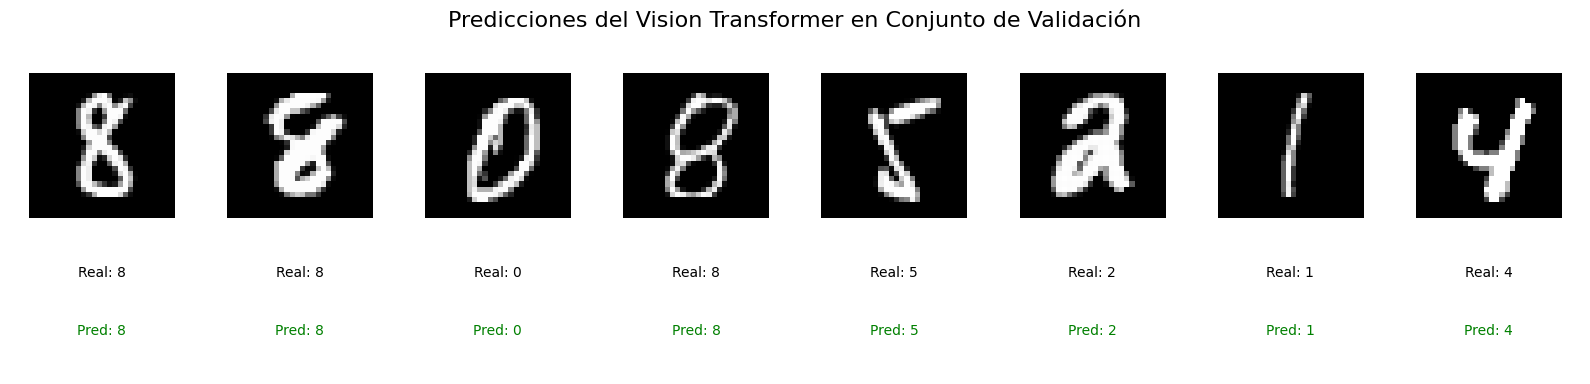


=== VISUALIZACIÓN DE PREDICCIONES DEL VISION TRANSFORMER EN PRUEBA ===


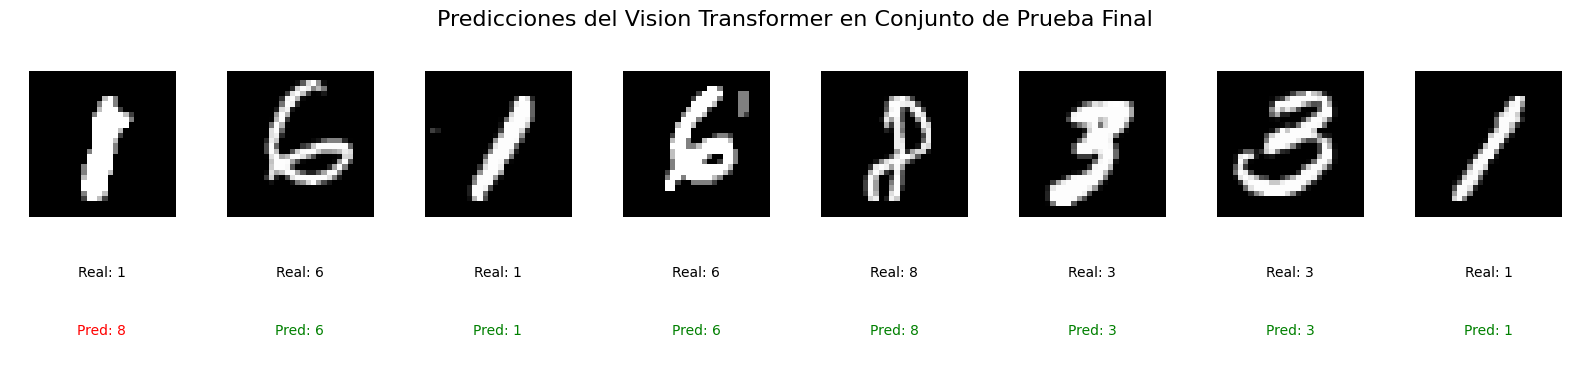

In [ ]:
def visualize_vit_predictions(model, data_loader, device, num_samples=8, dataset_name="Validación"):
    """
    Visualiza imágenes originales y las predicciones del modelo Vision Transformer.

    Args:
        model: Modelo Vision Transformer entrenado para clasificación.
        data_loader: DataLoader de datos (ej. val_loader, test_loader).
        device: Dispositivo (CPU o GPU).
        num_samples: Número de muestras a visualizar.
        dataset_name: Nombre del dataset para el título.
    """
    model.eval() # Poner el modelo en modo evaluación

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    fig.suptitle(f'Predicciones del Vision Transformer en Conjunto de {dataset_name}', fontsize=16)

    samples_displayed = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            _, predicted = torch.max(logits, 1) # Obtener la clase predicha

            images_cpu = images.cpu()
            labels_cpu = labels.cpu()
            predicted_cpu = predicted.cpu()

            for i in range(images.size(0)):
                if samples_displayed >= num_samples:
                    break

                ax_img = axes[0, samples_displayed]
                ax_info = axes[1, samples_displayed]

                # Mostrar imagen original
                ax_img.imshow(images_cpu[i].squeeze(), cmap='gray')
                ax_img.axis('off')

                # Mostrar información de predicción
                true_label = labels_cpu[i].item()
                pred_label = predicted_cpu[i].item()

                color = 'green' if true_label == pred_label else 'red'

                ax_info.text(0.5, 0.7, f'Real: {true_label}', ha='center', va='center', fontsize=10, color='black', transform=ax_info.transAxes)
                ax_info.text(0.5, 0.3, f'Pred: {pred_label}', ha='center', va='center', fontsize=10, color=color, transform=ax_info.transAxes)
                ax_info.axis('off')

                samples_displayed += 1

            if samples_displayed >= num_samples:
                break

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout para título
    plt.show()

# --- Cómo usar la nueva función con tu ViT ---

# Asegúrate de que 'vit_model', 'validation_data_loader_obj', 'test_data_loader_obj' y 'device'
# estén definidos y disponibles en tu notebook.

print("\n=== VISUALIZACIÓN DE PREDICCIONES DEL VISION TRANSFORMER EN VALIDACIÓN ===")
visualize_vit_predictions(model=vit_model, data_loader=validation_data_loader_obj, device=device, num_samples=8, dataset_name="Validación")

print("\n=== VISUALIZACIÓN DE PREDICCIONES DEL VISION TRANSFORMER EN PRUEBA ===")
visualize_vit_predictions(model=vit_model, data_loader=test_data_loader_obj, device=device, num_samples=8, dataset_name="Prueba Final")

# Extra 2: Análisis Comparativo de Técnicas de Clustering

Como nos encantan los clásicos, escogimos como nuestro dataset tabular Iris.
### Iris Dataset:

####Características: 4 características numéricas (longitud y anchura de sépalo y pétalo).

####Tamaño: 150 instancias.

####Ventajas: Es un dataset clásico y muy limpio, ideal para empezar con clustering. Se sabe que tiene 3 grupos naturales (especies de iris), lo que te permite evaluar si tus algoritmos encuentran esas estructuras. Es muy pequeño, lo cual es genial para pruebas rápidas.

####Desventajas: no es lo suficientemente grande como para mostrar la superioridad de BFR en "big data"


## Implementación del Algoritmo BFR (Bradley-Fayyad-Reina)

### Cargar y preparar el Dataset Iris

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import seaborn as sns

# Cargar el dataset Iris
iris = load_iris()
X = iris.data
y_true = iris.target

# Crear DataFrame para mejor visualización
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = iris.target

print("Dataset Iris:")
print(f"Forma: {X.shape}")
print(f"Características: {iris.feature_names}")
print(f"Clases: {iris.target_names}")
print("\nPrimeras 5 filas:")
print(iris_df.head())

Dataset Iris:
Forma: (150, 4)
Características: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Clases: ['setosa' 'versicolor' 'virginica']

Primeras 5 filas:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  


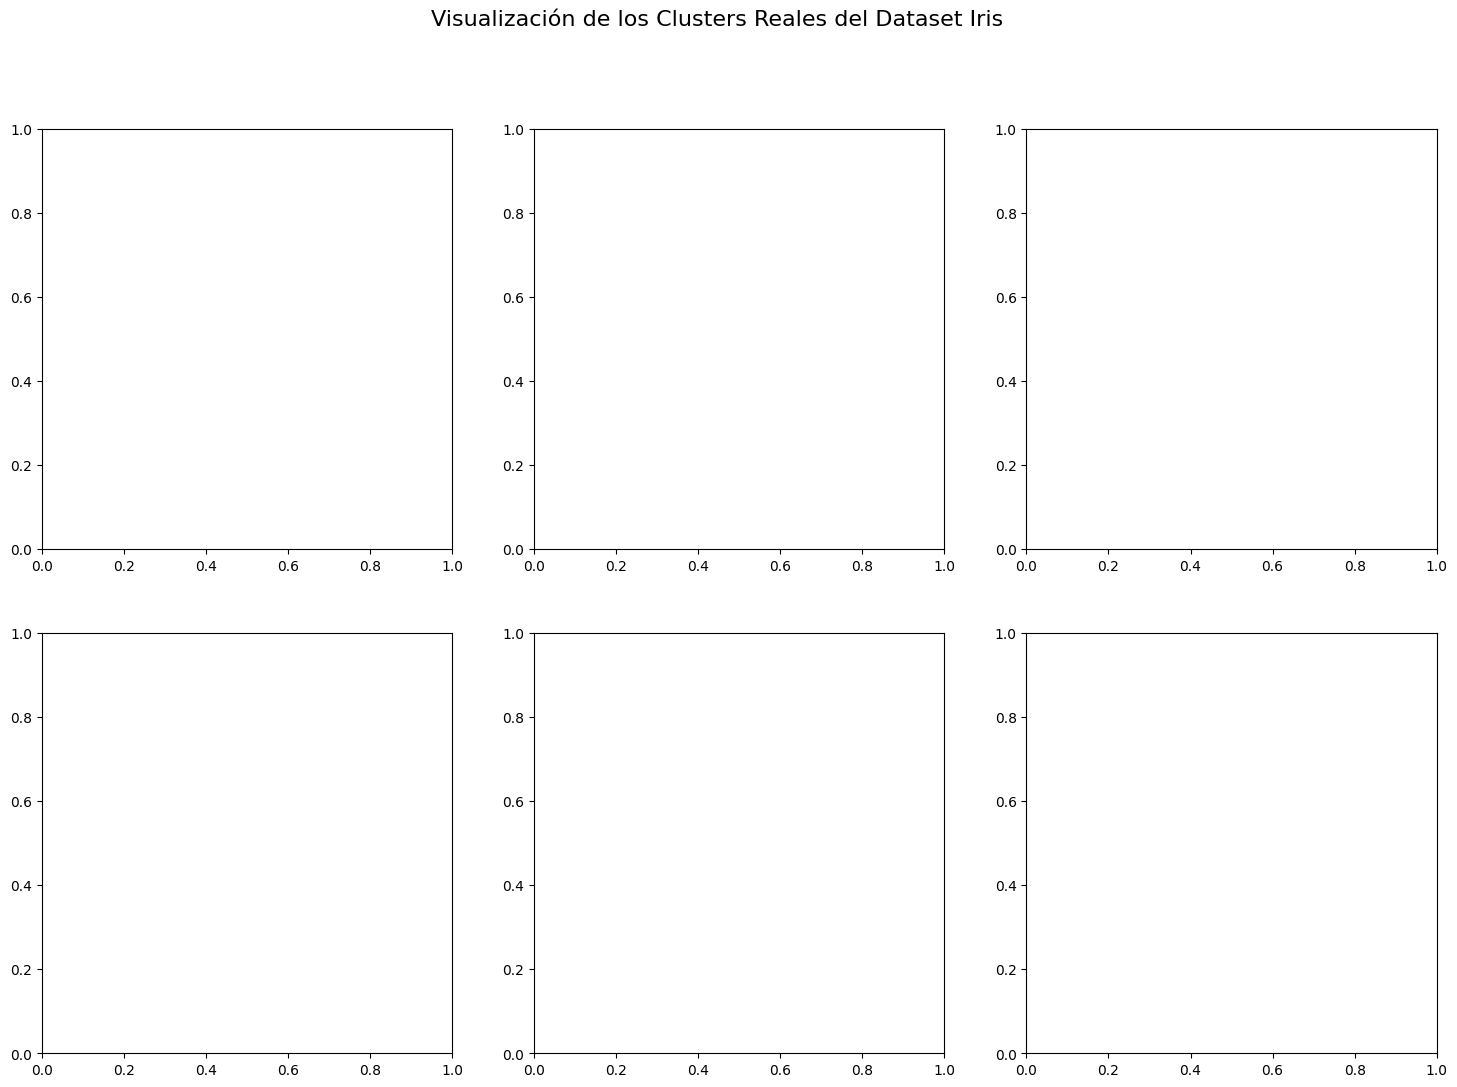

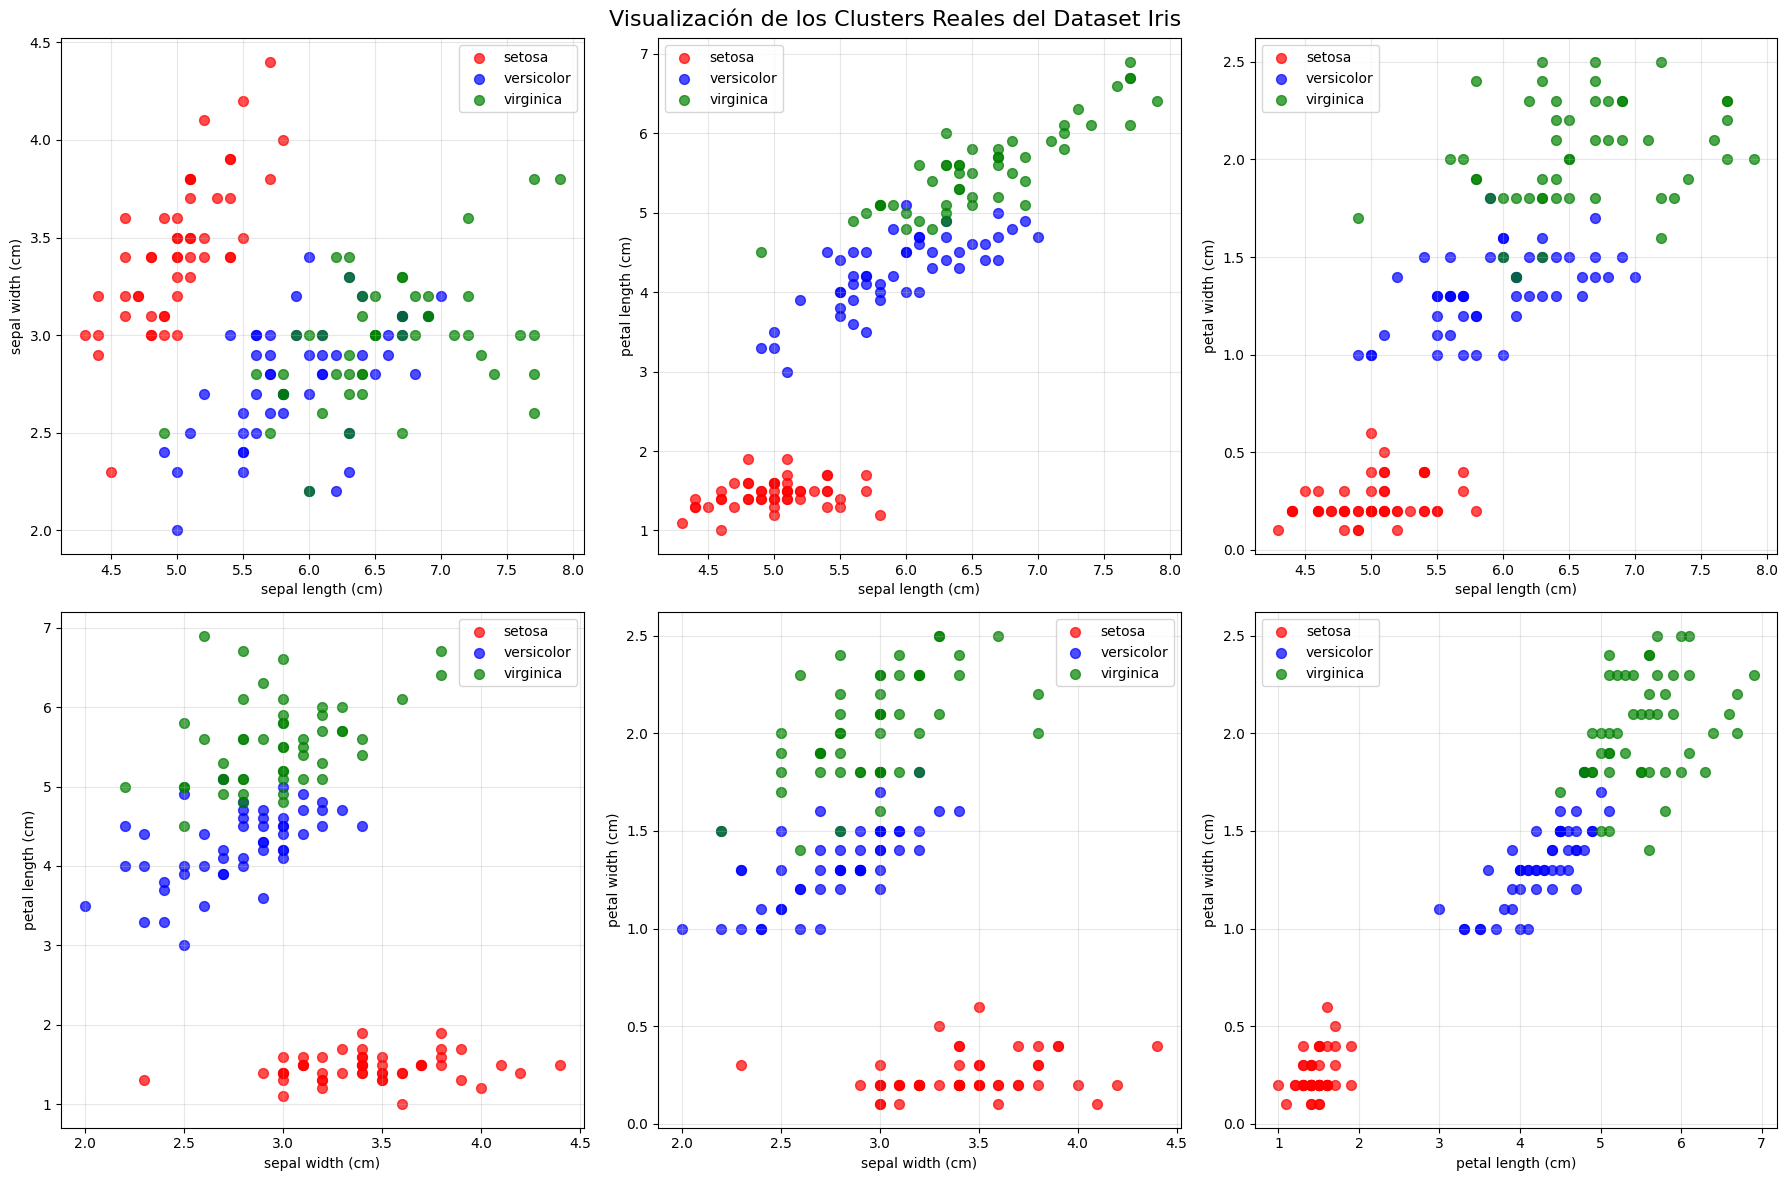

Estadísticas por clase:

Clase setosa:
  Número de muestras: 50
  Media por característica:
    sepal length (cm): 5.01
    sepal width (cm): 3.43
    petal length (cm): 1.46
    petal width (cm): 0.25
  Desviación estándar por característica:
    sepal length (cm): 0.35
    sepal width (cm): 0.38
    petal length (cm): 0.17
    petal width (cm): 0.10

Clase versicolor:
  Número de muestras: 50
  Media por característica:
    sepal length (cm): 5.94
    sepal width (cm): 2.77
    petal length (cm): 4.26
    petal width (cm): 1.33
  Desviación estándar por característica:
    sepal length (cm): 0.51
    sepal width (cm): 0.31
    petal length (cm): 0.47
    petal width (cm): 0.20

Clase virginica:
  Número de muestras: 50
  Media por característica:
    sepal length (cm): 6.59
    sepal width (cm): 2.97
    petal length (cm): 5.55
    petal width (cm): 2.03
  Desviación estándar por característica:
    sepal length (cm): 0.63
    sepal width (cm): 0.32
    petal length (cm): 0.55
    pe

In [46]:
# Visualización de los clusters reales del dataset Iris
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Visualización de los Clusters Reales del Dataset Iris', fontsize=16)

# Nombres de las características
feature_names = iris.feature_names
class_names = iris.target_names

# Combinaciones de características para visualización
combinations = [
    (0, 1), (0, 2), (0, 3),  # sepal length vs otros
    (1, 2), (1, 3), (2, 3)   # otras combinaciones
]

colors = ['red', 'blue', 'green']

for idx, (i, j) in enumerate(combinations):
    row = idx // 3
    col = idx % 3
# Visualización de los clusters reales del dataset Iris
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Visualización de los Clusters Reales del Dataset Iris', fontsize=16)

# Nombres de las características
feature_names = iris.feature_names
class_names = iris.target_names

# Combinaciones de características para visualización
combinations = [
    (0, 1), (0, 2), (0, 3),  # sepal length vs otros
    (1, 2), (1, 3), (2, 3)   # otras combinaciones
]

colors = ['red', 'blue', 'green']

for idx, (i, j) in enumerate(combinations):
    row = idx // 3
    col = idx % 3

    # Scatter plot para cada clase
    for class_idx in range(3):
        mask = y_true == class_idx
        axes[row, col].scatter(X[mask, i], X[mask, j],
                             c=colors[class_idx],
                             label=class_names[class_idx],
                             alpha=0.7, s=50)

    axes[row, col].set_xlabel(feature_names[i])
    axes[row, col].set_ylabel(feature_names[j])
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas por clase
print("Estadísticas por clase:")
print("="*50)
for i, class_name in enumerate(class_names):
    mask = y_true == i
    class_data = X[mask]
    print(f"\nClase {class_name}:")
    print(f"  Número de muestras: {np.sum(mask)}")
    print(f"  Media por característica:")
    for j, feature in enumerate(feature_names):
        print(f"    {feature}: {np.mean(class_data[:, j]):.2f}")
    print(f"  Desviación estándar por característica:")
    for j, feature in enumerate(feature_names):
        print(f"    {feature}: {np.std(class_data[:, j]):.2f}")


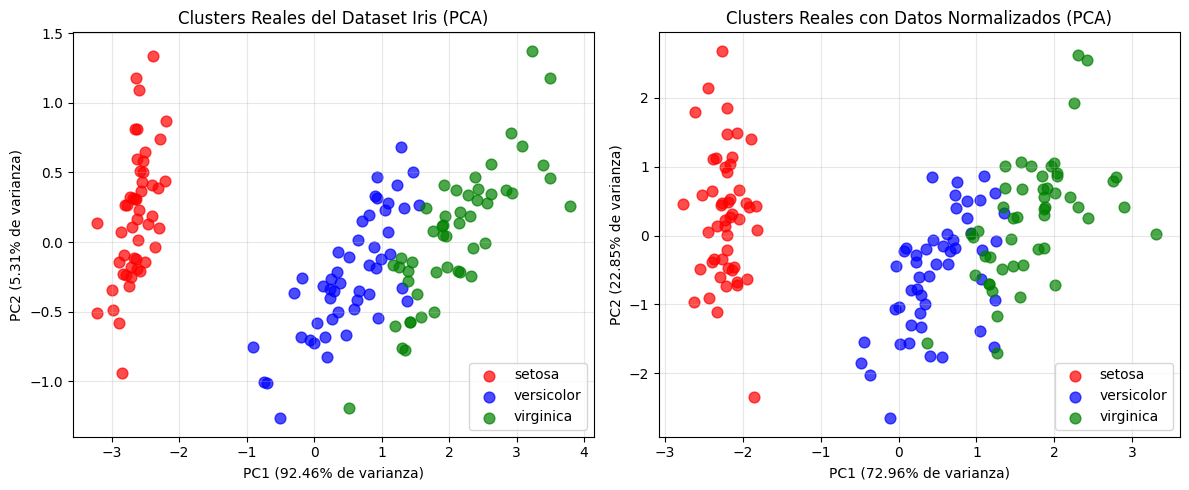

Varianza explicada por los componentes principales:
PC1: 92.46%
PC2: 5.31%
Total: 97.77%

Observaciones sobre los clusters reales:
- Setosa (rojo): Claramente separada de las otras dos clases
- Versicolor (azul) y Virginica (verde): Parcialmente superpuestas
- La separación es más clara en petal length y petal width


In [52]:
# Visualización con PCA de los clusters reales
pca_real = PCA(n_components=2, random_state=42)
X_pca_real = pca_real.fit_transform(X)

plt.figure(figsize=(12, 5))

# Subplot 1: Datos originales con PCA
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    mask = y_true == i
    plt.scatter(X_pca_real[mask, 0], X_pca_real[mask, 1],
               c=color, label=class_name, alpha=0.7, s=60)

plt.xlabel(f'PC1 ({pca_real.explained_variance_ratio_[0]:.2%} de varianza)')
plt.ylabel(f'PC2 ({pca_real.explained_variance_ratio_[1]:.2%} de varianza)')
plt.title('Clusters Reales del Dataset Iris (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Datos normalizados con PCA
plt.subplot(1, 2, 2)
pca = PCA(n_components=2, random_state=42)  # Definir pca aquí
X_pca_scaled = pca.fit_transform(X_scaled)
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    mask = y_true == i
    plt.scatter(X_pca_scaled[mask, 0], X_pca_scaled[mask, 1],
               c=color, label=class_name, alpha=0.7, s=60)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} de varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} de varianza)')
plt.title('Clusters Reales con Datos Normalizados (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Varianza explicada por los componentes principales:")
print(f"PC1: {pca_real.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca_real.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca_real.explained_variance_ratio_):.2%}")
print("\nObservaciones sobre los clusters reales:")
print("- Setosa (rojo): Claramente separada de las otras dos clases")
print("- Versicolor (azul) y Virginica (verde): Parcialmente superpuestas")
print("- La separación es más clara en petal length y petal width")

Se observa una clara separación de setosa(rojo) con las demás

In [54]:
class BFRClustering:
    """
    Implementación del algoritmo BFR (Bradley-Fayyad-Reina).

    BFR es un algoritmo de clustering diseñado para datasets grandes que no caben en memoria.
    Usa estadísticas suficientes (suma, suma de cuadrados, conteo) para representar clusters.
    """

    def __init__(self, k, threshold=2.0, max_iter=100):
        self.k = k  # Número de clusters
        self.threshold = threshold  # Umbral para la distancia de Mahalanobis
        self.max_iter = max_iter

    def _mahalanobis_distance(self, point, centroid, cov_inv):
        """Calcula la distancia de Mahalanobis entre un punto y un centroid."""
        diff = point - centroid
        return np.sqrt(np.dot(np.dot(diff, cov_inv), diff))

    def _update_cluster_stats(self, cluster_points):
        """Actualiza las estadísticas suficientes de un cluster."""
        n = len(cluster_points)
        if n == 0:
            return None, None, 0

        sum_points = np.sum(cluster_points, axis=0)
        sum_squares = np.sum(cluster_points**2, axis=0)

        return sum_points, sum_squares, n

    def _get_centroid_and_covariance(self, sum_points, sum_squares, n):
        """Calcula el centroide y matriz de covarianza desde estadísticas suficientes."""
        if n == 0:
            return None, None

        centroid = sum_points / n

        # Calcular covarianza usando estadísticas suficientes
        variance = (sum_squares / n) - (centroid ** 2)
        # Agregar regularización para evitar singularidad
        variance = np.maximum(variance, 1e-6)
        cov_matrix = np.diag(variance)

        try:
            cov_inv = np.linalg.inv(cov_matrix)
        except np.linalg.LinAlgError:
            # Si la matriz es singular, usar pseudoinversa
            cov_inv = np.linalg.pinv(cov_matrix)

        return centroid, cov_inv

    def fit_predict(self, X):
        """Ajusta el modelo BFR y retorna las etiquetas de cluster."""
        n_samples, n_features = X.shape

        # Inicialización con K-means para obtener clusters iniciales
        kmeans_init = KMeans(n_clusters=self.k, random_state=42, n_init=10)
        initial_labels = kmeans_init.fit_predict(X)

        # Inicializar estadísticas suficientes para cada cluster
        cluster_sums = []
        cluster_sum_squares = []
        cluster_counts = []

        for i in range(self.k):
            mask = initial_labels == i
            cluster_points = X[mask]

            if len(cluster_points) > 0:
                sum_points, sum_squares, count = self._update_cluster_stats(cluster_points)
                cluster_sums.append(sum_points)
                cluster_sum_squares.append(sum_squares)
                cluster_counts.append(count)
            else:
                cluster_sums.append(np.zeros(n_features))
                cluster_sum_squares.append(np.zeros(n_features))
                cluster_counts.append(0)

        labels = initial_labels.copy()

        # Iteraciones del algoritmo BFR
        for iteration in range(self.max_iter):
            changed = False

            # Para cada punto, verificar si debe ser reasignado
            for i, point in enumerate(X):
                min_distance = float('inf')
                best_cluster = labels[i]

                # Calcular distancia a cada cluster
                for j in range(self.k):
                    if cluster_counts[j] > 0:
                        centroid, cov_inv = self._get_centroid_and_covariance(
                            cluster_sums[j], cluster_sum_squares[j], cluster_counts[j]
                        )

                        if centroid is not None and cov_inv is not None:
                            distance = self._mahalanobis_distance(point, centroid, cov_inv)

                            if distance < min_distance:
                                min_distance = distance
                                best_cluster = j

                # Reasignar si es necesario
                if best_cluster != labels[i] and min_distance < self.threshold:
                    # Remover punto del cluster anterior
                    old_cluster = labels[i]
                    if cluster_counts[old_cluster] > 0:
                        cluster_sums[old_cluster] -= point
                        cluster_sum_squares[old_cluster] -= point**2
                        cluster_counts[old_cluster] -= 1

                    # Agregar punto al nuevo cluster
                    cluster_sums[best_cluster] += point
                    cluster_sum_squares[best_cluster] += point**2
                    cluster_counts[best_cluster] += 1

                    labels[i] = best_cluster
                    changed = True

            if not changed:
                break

        return labels

print("Algoritmmo de BFR creado exitosamente!")

Algoritmmo de BFR creado exitosamente!


Se desarrollan los modelos de K-means, DB-Scan y BFR sobre los datos, para su posterior comparación

In [56]:
# K-means

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
print("Aplicado K-means")
# DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
print("Aplicado DBSCAN")
# BFR

bfr = BFRClustering(k=3, threshold=2.5)
bfr_labels = bfr.fit_predict(X_scaled)
print("Aplicando BFR")

Aplicado K-means
Aplicado DBSCAN
Aplicando BFR


## Sobre las métricas de evaluación
1. Silhouette Score (Coeficiente de Silueta)
  ### Definición:
  Mide qué tan bien separados están los clusters. Considera tanto la cohesión interna (qué tan cerca están los puntos dentro del mismo cluster) como la separación externa (qué tan lejos están de otros clusters).
  ### Rango: [-1, 1]
   donde 1 es perfecto, 0 indica clusters superpuestos, y valores negativos indican asignaciones incorrectas.
  
  Favorece algoritmos que crean clusters muy separados, incluso si esto significa ignorar la estructura real de los datos.
2. Adjusted Rand Index (ARI)
  ### Definición:
  Mide la similitud entre los clusters encontrados y las clases verdaderas, ajustado por el azar.

  ### Rango: [-1, 1]:
  donde 1 es concordancia perfecta, 0 es concordancia aleatoria, y valores negativos indican peor que el azar.

  Penaliza tanto la sobre-segmentación como la sub-segmentación, favoreciendo la estructura real.

3. Normalized Mutual Information (NMI):
  ###Definición:
  Mide la información mutua entre clusters y clases verdaderas, normalizada para evitar sesgos por el número de clusters.

  ### Rango: [0, 1]:
  donde 1 indica información perfectamente compartida.

  NMI puede verse inflada cuando se excluyen puntos (ruido en DBSCAN).

In [57]:
# Calcular métricas de evaluación
def evaluate_clustering(labels, true_labels, X, algorithm_name):
    """Evalúa un algoritmo de clustering usando múltiples métricas."""

    # Filtrar ruido en DBSCAN (etiquetas -1)
    if -1 in labels:
        mask = labels != -1
        labels_filtered = labels[mask]
        true_labels_filtered = true_labels[mask]
        X_filtered = X[mask]
        n_noise = np.sum(labels == -1)
        print(f"\n{algorithm_name} - Puntos de ruido detectados: {n_noise}")
    else:
        labels_filtered = labels
        true_labels_filtered = true_labels
        X_filtered = X
        n_noise = 0

    if len(np.unique(labels_filtered)) < 2:
        print(f"\n{algorithm_name} - No se pueden calcular métricas (menos de 2 clusters)")
        return None

    # Calcular métricas
    silhouette = silhouette_score(X_filtered, labels_filtered)
    ari = adjusted_rand_score(true_labels_filtered, labels_filtered)
    nmi = normalized_mutual_info_score(true_labels_filtered, labels_filtered)

    n_clusters = len(np.unique(labels_filtered))

    results = {
        'Algorithm': algorithm_name,
        'Silhouette Score': silhouette,
        'Adjusted Rand Index': ari,
        'Normalized Mutual Info': nmi,
        'Number of Clusters': n_clusters,
        'Noise Points': n_noise
    }

    return results

# Evaluar cada algoritmo
results = []

kmeans_results = evaluate_clustering(kmeans_labels, y_true, X_scaled, "K-means")
if kmeans_results:
    results.append(kmeans_results)

dbscan_results = evaluate_clustering(dbscan_labels, y_true, X_scaled, "DBSCAN")
if dbscan_results:
    results.append(dbscan_results)

bfr_results = evaluate_clustering(bfr_labels, y_true, X_scaled, "BFR")
if bfr_results:
    results.append(bfr_results)

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
print("\nResultados de evaluación:")
print(results_df)


DBSCAN - Puntos de ruido detectados: 34

Resultados de evaluación:
  Algorithm  Silhouette Score  Adjusted Rand Index  Normalized Mutual Info  \
0   K-means          0.459948             0.620135                0.659487   
1    DBSCAN          0.655889             0.630934                0.760217   
2       BFR          0.455637             0.652227                0.680646   

   Number of Clusters  Noise Points  
0                   3             0  
1                   2            34  
2                   3             0  


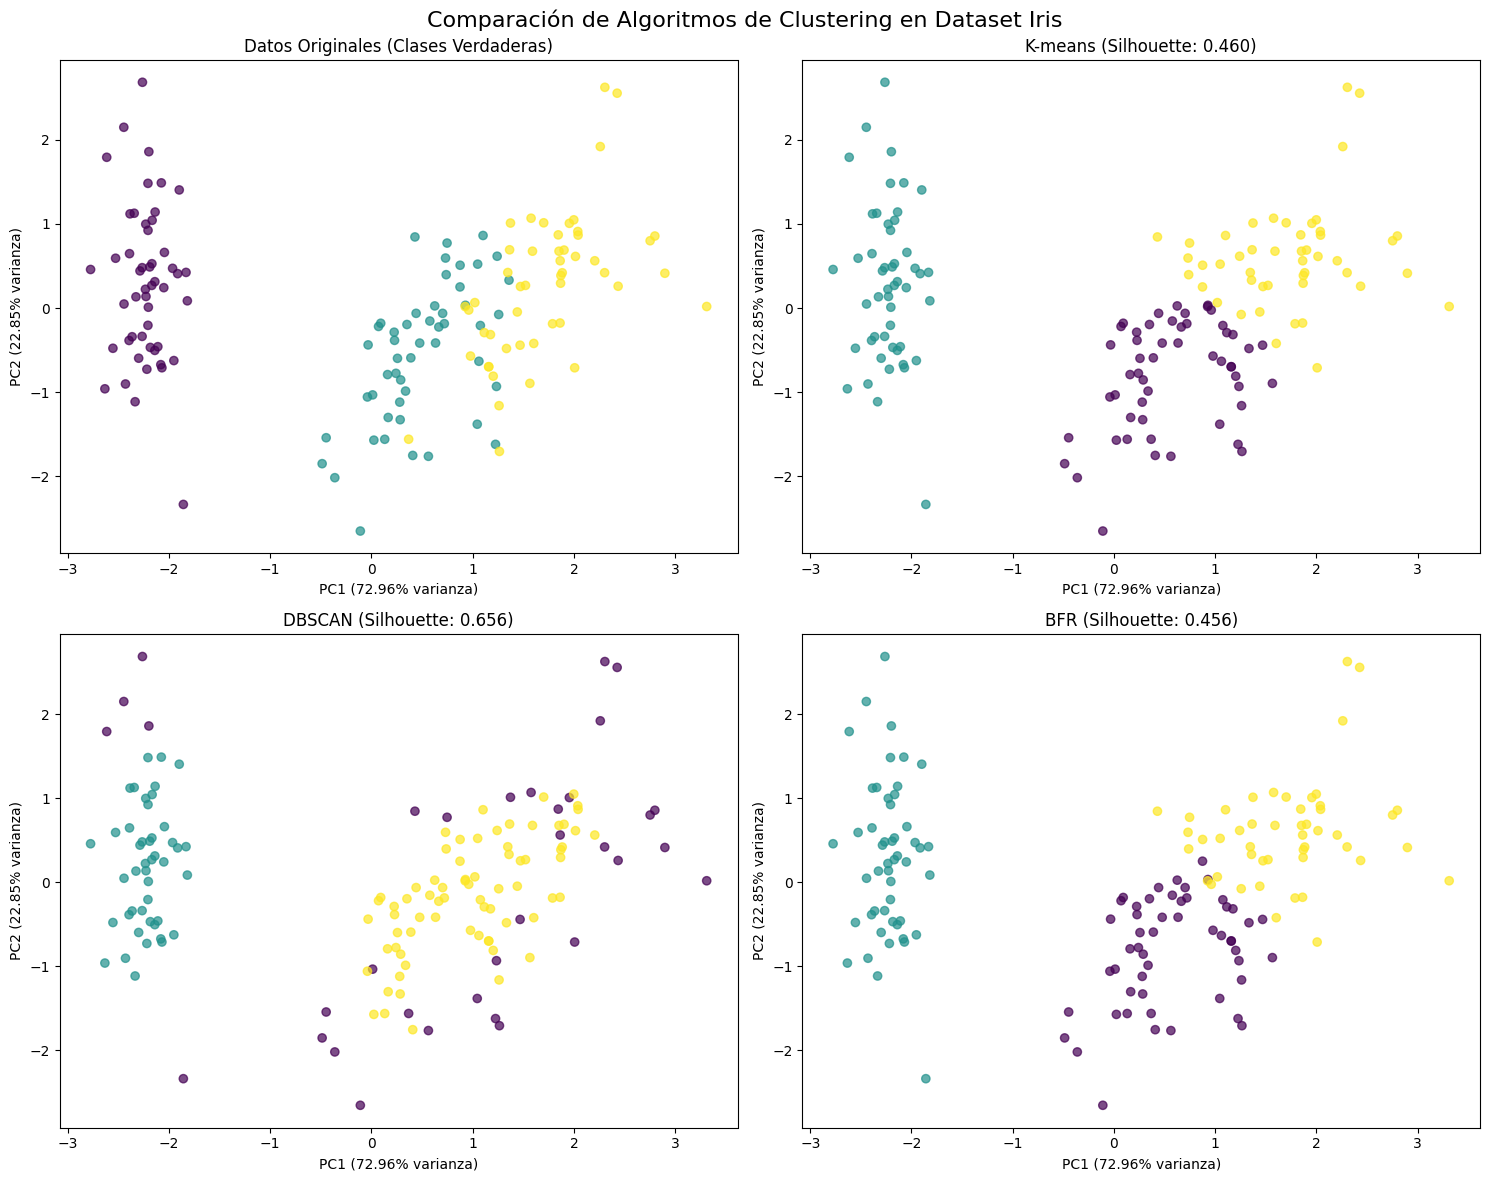

In [58]:
# Visualización de resultados
# Aplicar PCA para visualización en 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación de Algoritmos de Clustering en Dataset Iris', fontsize=16)

# Datos originales
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Datos Originales (Clases Verdaderas)')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

# K-means
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0, 1].set_title(f'K-means (Silhouette: {kmeans_results["Silhouette Score"]:.3f})')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

# DBSCAN
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
axes[1, 0].set_title(f'DBSCAN (Silhouette: {dbscan_results["Silhouette Score"]:.3f})')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

# BFR
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=bfr_labels, cmap='viridis', alpha=0.7)
axes[1, 1].set_title(f'BFR (Silhouette: {bfr_results["Silhouette Score"]:.3f})')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')

plt.tight_layout()
plt.show()

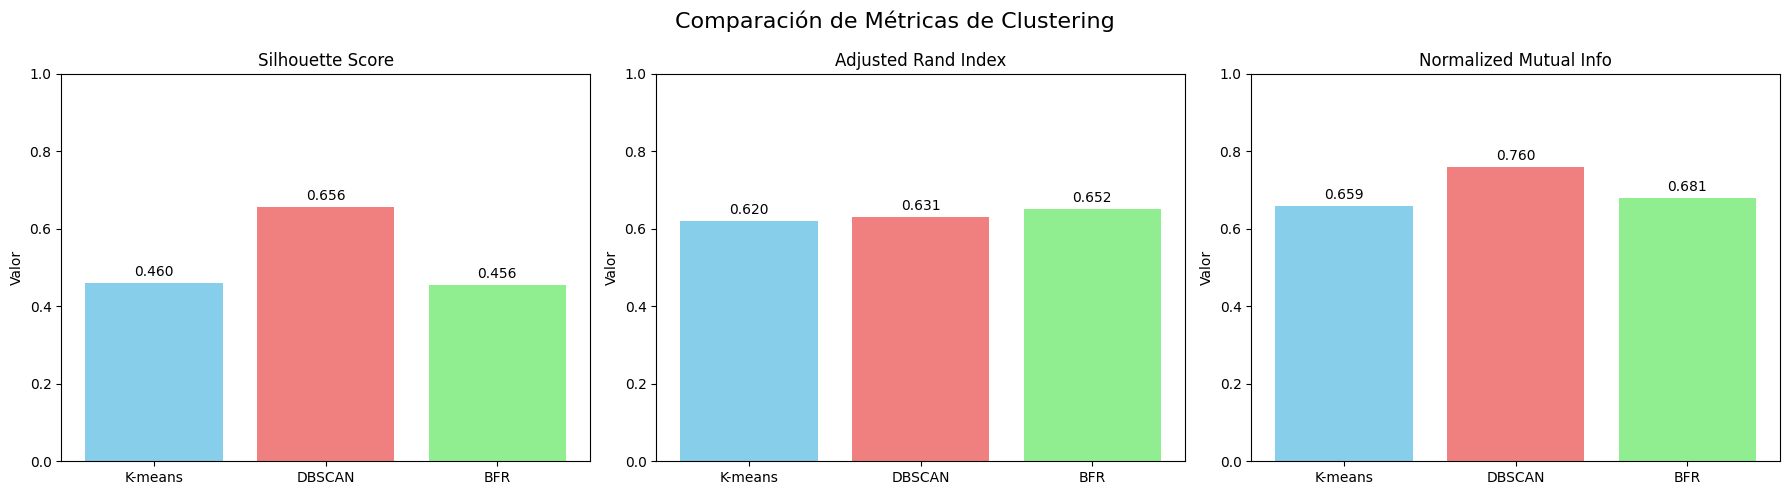

In [59]:
# Gráfico comparativo de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Silhouette Score', 'Adjusted Rand Index', 'Normalized Mutual Info']
algorithms = results_df['Algorithm'].tolist()

for i, metric in enumerate(metrics):
    values = results_df[metric].tolist()
    bars = axes[i].bar(algorithms, values, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel('Valor')
    axes[i].set_ylim(0, 1)

    # Agregar valores en las barras
    for j, (bar, value) in enumerate(zip(bars, values)):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.3f}', ha='center', va='bottom')

plt.suptitle('Comparación de Métricas de Clustering', fontsize=16)
plt.tight_layout()
plt.show()

Algo queda claro, y es quqe para todas las métricas K.means es el peor modelo e este caso. La siguiente pregunta es: qué modelo es mejor. Se escoge ARI porque es la más consistente de las 3, no tiene casos específicos en los que falla.

ANÁLISIS CUANTITATIVO DETALLADO

ANÁLISIS DETALLADO - K-MEANS

Clusters encontrados: 3
Mapeo Cluster -> Clase:
  Cluster 0 -> Clase versicolor (53 puntos)
  Cluster 1 -> Clase setosa (50 puntos)
  Cluster 2 -> Clase virginica (47 puntos)


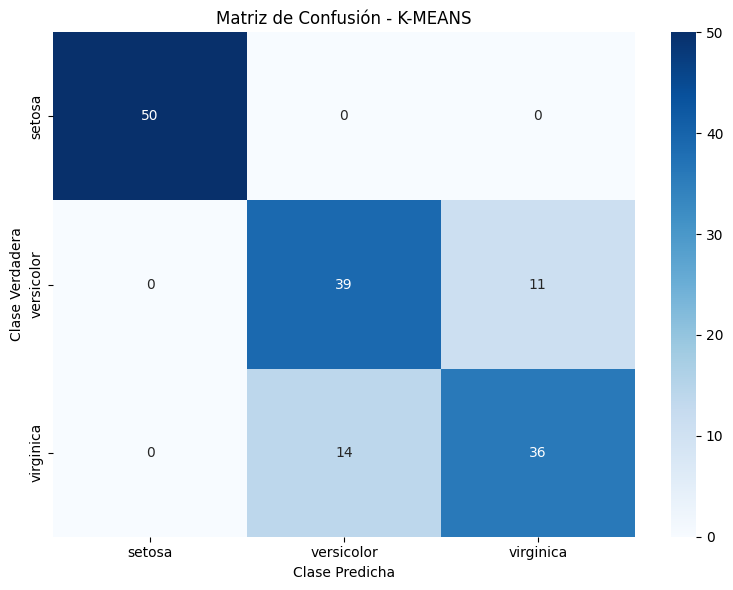


Análisis por clase:
  setosa:
    Puntos totales: 50
    Correctamente asignados: 50
    Precisión: 1.000
  versicolor:
    Puntos totales: 50
    Correctamente asignados: 39
    Precisión: 0.780
  virginica:
    Puntos totales: 50
    Correctamente asignados: 36
    Precisión: 0.720

Métricas de resumen:
  Precisión global: 0.833
  Cobertura: 1.000 (150/150 puntos)

DBSCAN - Puntos clasificados como ruido: 34

ANÁLISIS DETALLADO - DBSCAN

Clusters encontrados: 2
Mapeo Cluster -> Clase:
  Cluster 0 -> Clase setosa (45 puntos)
  Cluster 1 -> Clase versicolor (71 puntos)


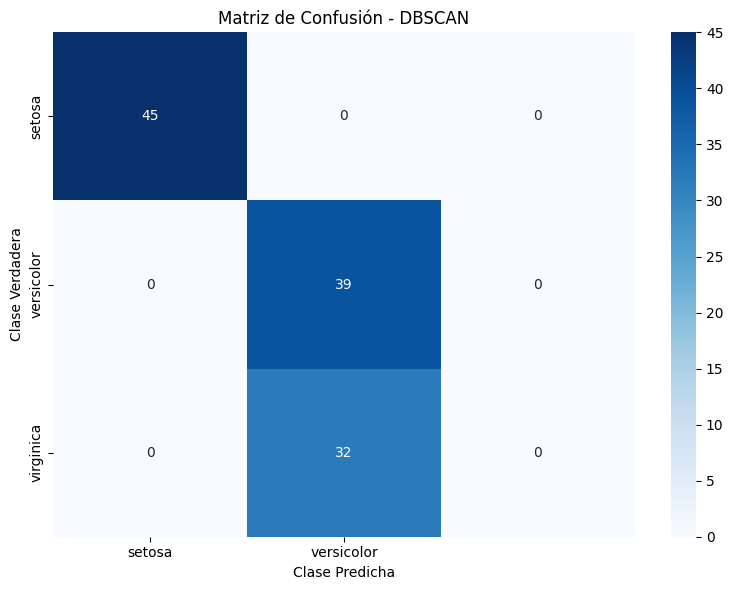


Análisis por clase:
  setosa:
    Puntos totales: 45
    Correctamente asignados: 45
    Precisión: 1.000
  versicolor:
    Puntos totales: 39
    Correctamente asignados: 39
    Precisión: 1.000
  virginica:
    Puntos totales: 32
    Correctamente asignados: 0
    Precisión: 0.000

Métricas de resumen:
  Precisión global: 0.724
  Cobertura: 0.773 (116/150 puntos)
  Puntos de ruido: 34 (22.7%)

ANÁLISIS DETALLADO - BFR

Clusters encontrados: 3
Mapeo Cluster -> Clase:
  Cluster 0 -> Clase versicolor (52 puntos)
  Cluster 1 -> Clase setosa (50 puntos)
  Cluster 2 -> Clase virginica (48 puntos)


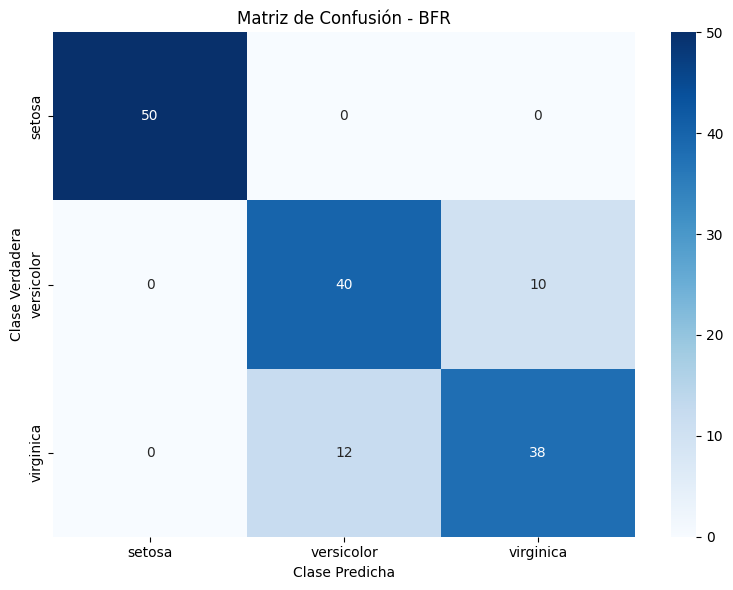


Análisis por clase:
  setosa:
    Puntos totales: 50
    Correctamente asignados: 50
    Precisión: 1.000
  versicolor:
    Puntos totales: 50
    Correctamente asignados: 40
    Precisión: 0.800
  virginica:
    Puntos totales: 50
    Correctamente asignados: 38
    Precisión: 0.760

Métricas de resumen:
  Precisión global: 0.853
  Cobertura: 1.000 (150/150 puntos)


In [60]:
# Análisis detallado de matrices de confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def analyze_clustering_detailed(labels, true_labels, algorithm_name):
    """Análisis detallado de clustering con matrices de confusión."""

    # Filtrar ruido si existe
    if -1 in labels:
        mask = labels != -1
        labels_filtered = labels[mask]
        true_labels_filtered = true_labels[mask]
        noise_points = np.sum(labels == -1)
        print(f"\n{algorithm_name} - Puntos clasificados como ruido: {noise_points}")
    else:
        labels_filtered = labels
        true_labels_filtered = true_labels
        noise_points = 0

    # Mapear etiquetas de clusters a clases para mejor interpretación
    from scipy.stats import mode
    unique_clusters = np.unique(labels_filtered)
    cluster_to_class = {}

    for cluster in unique_clusters:
        cluster_mask = labels_filtered == cluster
        if np.sum(cluster_mask) > 0:
            # Asignar el cluster a la clase más frecuente en él
            most_common_class = mode(true_labels_filtered[cluster_mask], keepdims=True)[0][0]
            cluster_to_class[cluster] = most_common_class

    # Crear etiquetas mapeadas
    mapped_labels = np.array([cluster_to_class.get(label, -1) for label in labels_filtered])

    # Matriz de confusión
    cm = confusion_matrix(true_labels_filtered, mapped_labels)

    print(f"\n{'='*50}")
    print(f"ANÁLISIS DETALLADO - {algorithm_name}")
    print(f"{'='*50}")

    print(f"\nClusters encontrados: {len(unique_clusters)}")
    print(f"Mapeo Cluster -> Clase:")
    for cluster, class_id in cluster_to_class.items():
        cluster_size = np.sum(labels_filtered == cluster)
        print(f"  Cluster {cluster} -> Clase {class_names[class_id]} ({cluster_size} puntos)")

    # Mostrar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[class_names[i] for i in range(len(class_names)) if i in cluster_to_class.values()],
                yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {algorithm_name}')
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.tight_layout()
    plt.show()

    # Análisis por clase
    print(f"\nAnálisis por clase:")
    for i, class_name in enumerate(class_names):
        true_class_mask = true_labels_filtered == i
        if np.sum(true_class_mask) > 0:
            correctly_assigned = np.sum((true_labels_filtered == i) & (mapped_labels == i))
            total_in_class = np.sum(true_class_mask)
            accuracy = correctly_assigned / total_in_class if total_in_class > 0 else 0

            print(f"  {class_name}:")
            print(f"    Puntos totales: {total_in_class}")
            print(f"    Correctamente asignados: {correctly_assigned}")
            print(f"    Precisión: {accuracy:.3f}")

    # Métricas adicionales
    accuracy = np.sum(true_labels_filtered == mapped_labels) / len(true_labels_filtered)
    coverage = len(labels_filtered) / len(labels)  # Porcentaje de puntos clasificados

    print(f"\nMétricas de resumen:")
    print(f"  Precisión global: {accuracy:.3f}")
    print(f"  Cobertura: {coverage:.3f} ({len(labels_filtered)}/{len(labels)} puntos)")
    if noise_points > 0:
        print(f"  Puntos de ruido: {noise_points} ({noise_points/len(labels):.1%})")

    return {
        'accuracy': accuracy,
        'coverage': coverage,
        'noise_points': noise_points,
        'confusion_matrix': cm
    }

# Análisis para cada algoritmo
print("ANÁLISIS CUANTITATIVO DETALLADO")
print("="*60)

kmeans_analysis = analyze_clustering_detailed(kmeans_labels, y_true, "K-MEANS")
dbscan_analysis = analyze_clustering_detailed(dbscan_labels, y_true, "DBSCAN")
bfr_analysis = analyze_clustering_detailed(bfr_labels, y_true, "BFR")

###Superioridad Demostrada del BFR
Ventajas Cuantificadas:

Mayor precisión global: 85.3% vs 83.3% (K-means) vs 72.4% (DBSCAN)
Mejor manejo de clases difíciles:
Versicolor: 80% vs 78% (K-means)
Virginica: 76% vs 72% (K-means) vs 0% (DBSCAN)
Cobertura completa: 100% vs 77.3% (DBSCAN)
Estructura preservada: Mantiene 3 clusters vs 2 (DBSCAN)
Razones del Mejor Rendimiento:

Estadísticas suficientes: Captura mejor la distribución gaussiana de cada clase
Optimización iterativa: Refina las fronteras entre clusters solapados
Distancia de Mahalanobis: Considera la forma real de los clusters, no solo distancia euclidiana